In [1]:
#for reading files
import glob
import tifffile

#math computation and data organization
import numpy as np
import math
import scipy
from scipy.ndimage import binary_erosion, binary_fill_holes
from scipy import optimize
from scipy.optimize import curve_fit
import pandas as pd

# For loading bars
from tqdm.notebook import tqdm as tqdm

#For image plotting
import skimage.io

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian, threshold_mean
from skimage.measure import regionprops
import cv2

#for fitting
from lmfit import minimize, Parameters, fit_report

#for image registration
from skimage.registration import phase_cross_correlation
import os

#Matplotlib plotting packages
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import gridspec

import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")

#Movie
import celluloid as cell
import matplotlib.animation as animation

#for saving data
import csv
import h5py

#custom analysis packages
import aster_packages as ap #### commented out 20241114 since lucida fonts are not installed...

# Thing to enable lovely parallelization
import concurrent.futures

# Enable repeat from itertools for parallel
import itertools

#time elements for testing runtimes and using todays date
import time
from datetime import datetime

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts for editable text in PDFs

In [3]:
######### gabe hacky styling to emulate some of PBoC Phillips lab style conventions, however hacky. tries to make easier for nigel++
## Styling
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
# sns.set_style('ticks')

import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set the property to save figures with text as text, not paths
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# default good PBoC colors
baseBlendColor=(224/255, 219/255, 209/255,1) # default background for plots
contrastColor=(209/255, 193/255, 171/255,1) # slightly darker tan for contrasts, e.g. in inset boxes
yellowTanHighlightBoxColor='#FEF0C6'
goodGreyGreenArrowColor='#CCD4C9'

### Griffin style invocation

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.path import Path
from matplotlib.patches import BoxStyle
from matplotlib.offsetbox import AnchoredText

def plotting_style(grid=False):
    """
    Sets the style to the publication style. To instantiate, simply call
    plotting_style() at the beginning of your script or notebook to force
    all matplotlib plots to adopt the scheme.

    Parameters
    ----------
    grid: bool
      If True, plots will have a thin, white grid in the background. Default
      is False.

    Returns
    -------
    colors: dict
      Returns a dictionary of the standard PBoC 2e color palette.
    """
    rc = {'axes.facecolor': '#E3DCD0',
#               'axes.spines.top': False,
#               'axes.spines.right': False,
#               'axes.spines.left': False,  # Ensure left spine is present
#               'axes.spines.bottom': False,  # Ensure bottom spine is present
#               'axes.spines.left': False, #{'color': '#E3DCD0', 'linewidth': 1.5},  # Set the spine color to the background color
#               'axes.spines.bottom': False, #{'color': '#E3DCD0', 'linewidth': 1.5},  # Set the spine color to the background color
          #'font.family': '/usr/share/fonts/truetype/LucidaSansOT.otf', #'LucidaSansOT.otf',
          'grid.linestyle': '-',
          'grid.linewidth': 0.5,
          'grid.alpha': 0.75,
          'grid.color': '#ffffff',
          'axes.grid': grid,
          'ytick.direction': 'in',
          'xtick.direction': 'in',
          'xtick.gridOn': grid,
          'ytick.gridOn': grid,
#               'ytick.major.width':8,
#               'xtick.major.width':8,
#               'ytick.major.size': 8,
#               'xtick.major.size': 8,
          'mathtext.fontset': 'stixsans',
          'mathtext.sf': 'sans',
          'legend.frameon': True,
          'legend.facecolor': '#FFEDCE',
          'figure.dpi': 150,
          'xtick.color': 'k',
          'ytick.color': 'k'
         }
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('mathtext', fontset='stixsans', sf='sans')
    sns.set_style('darkgrid', rc=rc)
    return color_palette()

def color_palette():
    """
    Returns a dictionary of the PBOC color palette
    """
    return {'green': '#7AA974', 'light_green': '#BFD598',
              'pale_green': '#DCECCB', 'yellow': '#EAC264',
              'light_yellow': '#F3DAA9', 'pale_yellow': '#FFEDCE',
              'blue': '#738FC1', 'light_blue': '#A9BFE3',
              'pale_blue': '#C9D7EE', 'red': '#D56C55', 'light_red': '#E8B19D',
              'pale_red': '#F1D4C9', 'purple': '#AB85AC',
              'light_purple': '#D4C2D9', 'dark_green':'#7E9D90', 'dark_brown':'#905426'}

def titlebox(
    ax, text, color, bgcolor=None, size=8, boxsize=0.1, pad=0.05, **kwargs
):
    """
    Sets a colored title box above the plot, spanning the entire plot width.

    Parameters
    ----------
    ax : matplotlib axis object
      The axis on which you want to add the titlebox.
    text: str
      The title tect
    bgcolor: str or None
      The background color of the title box. Default is no color (blank).
    size:  int
      Size of the text font
    boxsize: float [0, 1]
      Fraction of the total plot height to be occupied by the box. Default is 10% (0.1).
    pad: float
      The padding space between the title box and the top of the plot.

    """
    boxsize=str(boxsize * 100)  + '%'
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size=boxsize, pad=pad)
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.spines["top"].set_visible(False)
    cax.spines["right"].set_visible(False)
#     cax.spines["bottom"].set_visible(False)
#     cax.spines["left"].set_visible(False)

#     cax.spines["bottom"].set_visible(True)
#     cax.spines["left"].set_visible(True)
#     cax.spines["left"].set_color("white")
#     cax.spines["bottom"].set_color("white")
#     cax.spines["bottom"].set_color("white")

#     cax.set_ticks_position('both')  # Adding ticks to both top and bottom
#     cax.yaxis.set_tick_params(direction='in', which='both', color='white')  # The bottom will maintain the default of 'out'


    plt.setp(cax.spines.values(), color=color)
    if bgcolor != None:
        cax.set_facecolor(bgcolor)
    else:
        cax.set_facecolor("white")
    at = AnchoredText(text, loc=10, frameon=False, prop=dict(size=size, color=color))
    cax.add_artist(at)


### Now actually call it
plotting_style()

import matplotlib.patheffects as pe
matplotlib.rcParams['axes.autolimit_mode'] = 'data'

# Data Imports
Function to import aster images into a list of length 3 each containing an image array for each channel with shape (lenth of frames, n by m image shape)

In [4]:
def parse_ome(file, channel_list=['405', '480', 'Cherry']):
    """
    Extracts image arrays from an ome.tif file.
    
    Parameters:
    file (string): Data file path.
    channel_list (list of strings): Names of fluorescent channels taken in this dataset
    
    Returns:
    (list): List of images (as 3D numpy.ndarrays) for each fluorescent channel with shape (# images, m, n).
    """
    
    images = []
    # Open and read the OME-TIFF file
    with tifffile.TiffFile(file) as tif:

        for i, page in enumerate(tif.pages):
            image_data = page.asarray()
            images.append(image_data)

        # Access the OME metadata if needed
        ome_metadata = tif.ome_metadata

    ch1 = images[0::3]
    ch2 = images[1::3]
    ch3 = images[2::3]
    
    return [np.array(ch1), np.array(ch2), np.array(ch3)]

Function to parse experimental info from the data path name

In [5]:
def grab_expparams_ome(gname):
    """
    Parses a file name to fine experimental parameters.
    
    Parameters:
    gname (string): data file path.
    
    Returns:
    exp_file (string): Saves the ome.tif name of the dataset.
    interval (integer): The time interval between images in seconds.
    motor_conc (float): The total concentration of motor proteins in µM.
    motor_type (string): The motor species, i.e. NCD or K401.
    ATP_conc (float): The inital concentration of ATP in µM.
    tubulin_conc (float): The concentration of tubulin (in the form of MT) in µM
    probe_conc (float): The concentration of the ATP probe in µM.
    probe_type (string): the species of ATP probe, i.e. A81D or ATeam
    """
    exp_file = gname.split('/')[-1]
    interval = int(exp_file.split('sInter')[0])
    motor_conc = float(exp_file.split('_')[1].split('uM')[0])
    motor_type = exp_file.split('_')[2]
    ATP_conc = float(exp_file.split('_')[4].split('uM')[0])
    tubulin_conc = float(exp_file.split('_')[5].split('uM')[0])
    probe_conc = float(exp_file.split('_')[7].split('uM')[0])
    probe_type = exp_file.split('_')[8]
    
    exp_params = {'exp_file':exp_file,
                 'interval':interval,
                 'motor_conc':motor_conc,
                 'motor_type':motor_type,
                 'ATP_conc':ATP_conc,
                 'tubulin_conc':tubulin_conc,
                 'probe_conc':probe_conc,
                 'probe_type':probe_type}
    return exp_params

Function to import dark images

In [6]:
def grab_dark_avg(file_path_dark):
    """
    Imports a dark image.
 
    Parameters:
    file_path_dark (string): Data path for a dark image.
    
    Returns:
    dark_avg (numpy.ndarray): Dark image as a 2D array.
    """
    dark_files = np.sort(glob.glob(file_path_dark))
    dark_ims = ap.file_to_image(dark_files)
    dark_avg = np.average(dark_ims, axis=0)
    return dark_avg

Function to read calibration parameters

In [7]:
def grab_calparams(file_path_cal):
    """
    Imports ATP calibration parameters as a DataFrame.
    
    Parameters:
    file_path_cal (string): Data path to a text file with fitting parameters for ATP calibration
    
    Returns:
    cal_params (pd.DataFrame): DataFrame with ATP calibration fitting parameters.
    """
        
    #read the DataFrame
    #cal_params = pd.read_csv(cal_file_path+cal_file_folder+cal_file_name)\
    cal_params = pd.read_csv(file_path_cal)

    #add hill=1 if no hill specified
    if len(cal_params)==3:
        cal_params.loc[-1] = [3, 'nhill', 1, 0]
    
    #reindex
    cal_params = cal_params.set_index('Param')
    
    #drop the unnamed colum (from index of text file)
    cal_params = cal_params.drop(columns='Unnamed: 0')
    
    return cal_params

## Normalize Images
This corrects for uneven illumination. The light gradient that comes from instrumentation "should" be the same for each frame. Here, take the first frame of the image sequence and create a normalization matrix. This matrix is created by dividing each pixel in the image by the maximum pixel value, so that when you multiply the original image by the normalization matrix, the first frame will be a homogeneous image with the highest pixel value. All future frames can be multiplied by the matrix to remove the systematic light gradient

In [8]:
def backSubtract(arrs, dark_avg):
    """
    Subtracts camera dark noise from images
    
    Parameters:
    arrs (lsit): list of 3D numpy.ndarray's containing aster images where each array is from a different fluorescent channel.
    dark_avg (numpy.ndarray): 2D array image taken with the camera shutter closed of shape (m, n)
    
    Returns:
    (list): list of 3D numpy.ndarray's with dark camera noise subtracted.
    """
    return [arr-dark_avg for arr in arrs] # save processed images

Find pixels illuminated in the ATP channels for all timepoints

In [9]:
def intersect(arrs):
    """
    The camera has an occasional jitter, illuminating slightly different fields of view. This function finds pixels illluminated in all frames
    
    Parameters:
    arrs (lsit): list of 3D numpy.ndarray's containing aster images where each array is from a different fluorescent channel.
    
    Returns:
    (tuple): tuple containing the pixel coordinates for pixels illuminated in all images. The tuple has two 1D arrays, one for each image dimension.
    """
    _, numRows, numCols=arrs[0].shape
    
    #iterate through frame numbers
    severeIntersection=np.ones_like(arrs[0][0]);
    
    for fr in range(arrs[0].shape[0]): # for every timepoint
        #iterate through channels:
        ## Process the ATP channels first!
        im_bins=[]
        for arr in arrs[:2]: #exclude the motor channel!
            im_bin = (arr[fr,:,:] > threshold_otsu(arr[fr,:,:])).astype(np.uint8)
            im_bins.append(im_bin)
        intersectionBinImg=np.multiply(*im_bins) # This is defined for each frame/timepoint; it is the intersection between both channels' masks
        severeIntersection=np.multiply(severeIntersection, intersectionBinImg) # This accumulates the most severe intersection possible such that after iteration over all frames, all pixels not = 0 are visible/illuminated in every frame and every channel

    return np.where(severeIntersection.astype(int)) #returns where =1 (or True)

In [10]:
def fit_bivariate_quadratic_anyShape(vals, coord):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    binary_im (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Flatten the matrices for the least squares fitting
    I_flat = coord[0]
    J_flat = coord[1]
    Z_flat = vals

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly_anyShape(vals,coord):
    """ Given coordinates, this function returns the best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic_anyShape(vals, coord);
    I, J = coord[0], coord[1]
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted

In [11]:
def norm_unev(arrs_sub, mask_coords, allmask_coords):
    """
    Corrects uneven illumination by fitting an image to a bivariate polynomial, normalizing the polynomial, and dividing an array of images by this normalized matrix.
    
    Parameters:
    arrs_sub (list): Dark image subtracted list of image arrays.
    mask_coords (length 2 tuple): illumination mask coordinates (for one image)
    allmask_coords (slice): slice containing all the illumination coordinates with an extra dimension to account for all timepoints
    
    Returns:
    arr_ev (list): list of image arrays after the evening process.
    """
    #norm_mats = []
    arrs_ev = []
    
    for arr in arrs_sub:
        #compute the bivariate filter
        biv_filt = np.zeros_like(arr[0])
        biv_filt[mask_coords] = evaluateBivPoly_anyShape(arr[0, :, :][mask_coords], mask_coords)
        #norm_mats.append(norm_mat)
        
        #scale the normalization matrix such that the average value after multiplication is the same as the bs image
        scalar = np.mean(arr[0][mask_coords])/np.mean(arr[0][mask_coords]/biv_filt[mask_coords])
        norm_mat = scalar/biv_filt
        
        arrs_ev_temp = np.zeros_like(arr)
        arrs_ev_temp[allmask_coords]=arr[allmask_coords]*norm_mat[mask_coords]
        
        arrs_ev.append(arrs_ev_temp)
        
    return arrs_ev

# **start analysis**

# Read in motor images

In [12]:
# Place where the metadata file is found
metaDataFile='../../data/aster/20241114_footageComments_gnames.csv'
metaDF = pd.read_csv(metaDataFile)

# ## Includes
goodSubset=metaDF[metaDF['Note'].apply(lambda x: 'GOOD' in x)]#[np.isin(metaDF['Note'], "GOOD")]
gnameList=list('../../data/aster/'+goodSubset['child']+'/'+goodSubset['FILE']+'/'+goodSubset['Position'])

In [13]:
motorconcs = []
for gname in gnameList:
    motorconcs.append(grab_expparams_ome(gname)['motor_conc'])

In [14]:
images = []
for gname in tqdm(gnameList):
    images.append(parse_ome(gname))

  0%|          | 0/42 [00:00<?, ?it/s]

Subtract background

In [15]:
motims = [ims[2] for ims in images]

In [21]:
motimsbs=[]                                                    
for motarr in tqdm(motims):
    motimsbs.append(motarr-1920)

  0%|          | 0/42 [00:00<?, ?it/s]

crop outsides

In [23]:
cropL = np.s_[50:1150,50:500]
cropR = np.s_[50:1150, 1920-500:1920-50]

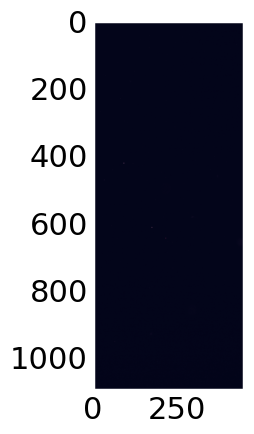

In [66]:
plt.imshow(motimsbs[0][0][cropR])

define lists for each crop containing only the first image or only the second image

In [24]:
motimsfirstL = [ims[0][cropL] for ims in motimsbs]
motimsfirstR = [ims[0][cropR] for ims in motimsbs] 
motimssecondL = [ims[1][cropL] for ims in motimsbs]
motimssecondR = [ims[1][cropR] for ims in motimsbs]

make coords

In [70]:
coords=np.where(motimsfirstL[0]!=np.inf)

normalize

In [78]:
biv_filt = np.zeros_like(motimsfirstL)
norm_mats_firstL = []
for i, im in enumerate(tqdm(motimsfirstL)):
    coords=np.where(motimsfirstL[i]!=np.inf) #get all the coordinates of the image
    biv_filt[i][coords] = evaluateBivPoly_anyShape(im[coords], coords)
    scalar = np.mean(im)/np.mean(im/biv_filt[i])
    norm_matsL.append(np.array(scalar/biv_filt[i]))
norm_mats_firstL=np.array(norm_matsL)

biv_filt = np.zeros_like(motimsfirstL)
norm_mats_secondL = []
for i, im in enumerate(tqdm(motimssecondL)):
    coords=np.where(motimssecondL[i]!=np.inf) #get all the coordinates of the image
    biv_filt[i][coords] = evaluateBivPoly_anyShape(im[coords], coords)
    scalar = np.mean(im)/np.mean(im/biv_filt[i])
    norm_mats_secondL.append(np.array(scalar/biv_filt[i]))
norm_mats_secondL=np.array(norm_mats_secondL)

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

whats the biggest deviation in the norm matrix between the 1st and 2nd frame

In [98]:
np.abs(norm_mats_firstL-norm_mats_secondL).max()

np.float64(3.3823673023207386)

In [123]:
np.unique(np.where(np.abs(np.array(norm_mats_firstL-norm_mats_secondL))>=np.abs(norm_mats_firstL-norm_mats_secondL).max())[0])

array([7])

its nubmer 7, checking it seems like the other ones are better and all at least sub 1 deviation so i am just going to proceed using the 2nd im norm matrix

In [124]:
biv_filt = np.zeros_like(motimssecondR)
norm_mats_secondR = []
for i, im in enumerate(tqdm(motimssecondR)):
    coords=np.where(motimssecondR[i]!=np.inf) #get all the coordinates of the image
    biv_filt[i][coords] = evaluateBivPoly_anyShape(im[coords], coords)
    scalar = np.mean(im)/np.mean(im/biv_filt[i])
    norm_mats_secondR.append(np.array(scalar/biv_filt[i]))

biv_filt = np.zeros_like(motimssecondL)
norm_mats_secondL = []
for i, im in enumerate(tqdm(motimssecondL)):
    coords=np.where(motimssecondL[i]!=np.inf) #get all the coordinates of the image
    biv_filt[i][coords] = evaluateBivPoly_anyShape(im[coords], coords)
    scalar = np.mean(im)/np.mean(im/biv_filt[i])
    norm_mats_secondL.append(np.array(scalar/biv_filt[i]))


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

apply the norm correction

In [128]:
motimfirstRev = []
motimfirstLev = []

for i in tqdm(range(len(motimsfirstR))):
    motimfirstRev.append(motimsfirstR[i]*norm_mats_secondR[i])
    motimfirstLev.append(motimsfirstL[i]*norm_mats_secondL[i])

  0%|          | 0/42 [00:00<?, ?it/s]

check how different bright spots make the average

In [139]:
motimfirstLev[0].max(), np.percentile(motimfirstLev[0], 99.99)

(np.float64(44495.03757053851), np.float64(511.3513731644379))

In [143]:
np.average(motimfirstLev[0][motimfirstLev[0]<=np.percentile(motimfirstLev[0], 99.99)]), np.average(motimfirstLev[0])

(np.float64(68.35449976315195), np.float64(68.6132065327635))

seems close enough, just average regularly

In [146]:
motimfirstRevavg = np.array([np.nanmean(im) for im in motimfirstRev])
motimfirstLevavg = np.array([np.nanmean(im) for im in motimfirstLev])

biggest deviation between right and left sides?

In [149]:
max((motimfirstRevavg-motimfirstLevavg)/motimfirstRevavg)

np.float64(0.04085201877207112)

cool not bad lets average both sides now

In [152]:
motimfirstevavg = (motimfirstLevavg+motimfirstRevavg)/2

ok lets plot it and fit it!

In [169]:
def linear(arr, a, b):
    return a*arr + b
def fitLinear(x, y, p0):
    param,_ = curve_fit(linear, x, y, p0)
    return param

[353.54121305 -11.88635826]


Text(0.5, 1.0, '$\\text{Intensity} = 354 [\\text{motor}] -12$')

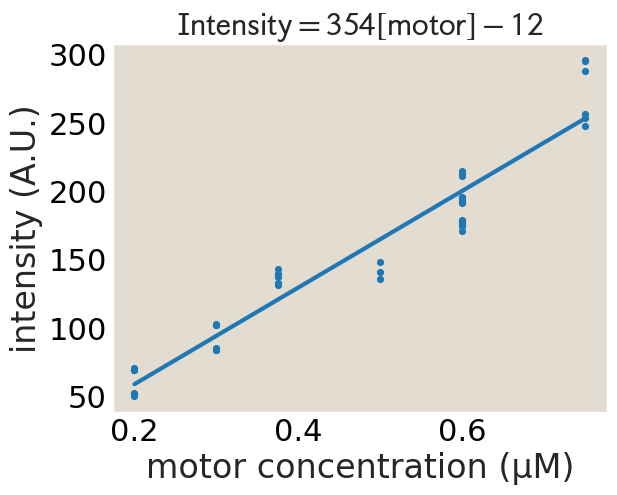

In [179]:
plt.scatter(motorconcs, motimfirstevavg, s=10)
motlinfit = fitLinear(motorconcs, motimfirstevavg, [450, -40])
print(motlinfit)
plt.plot(np.linspace(0.2, 0.75, 100), linear(np.linspace(0.2, 0.75, 100), motlinfit[0], motlinfit[1]))
plt.xlabel('motor concentration (µM)')
plt.ylabel('intensity (A.U.)')
plt.title(rf'$\text{{Intensity
}} = {round(motlinfit[0])} [\text{{motor}}] {round(motlinfit[1])}$')

# **Photobleaching**

crop all the images to the outside strips

In [15]:
allcropL = np.s_[:, 50:1150,50:500]
allcropR = np.s_[:, 50:1150, 1920-500:1920-50]

In [16]:
motimsL = []
motimsR = []
for gname in tqdm(gnameList):
    tempim = parse_ome(gname)[2]
    motimsL.append(tempim[allcropL])
    motimsR.append(tempim[allcropR])

  0%|          | 0/42 [00:00<?, ?it/s]

normalize matrix from first frame (and include background subtraction to have less things in memory)

In [23]:
norm_mats_firstR = []
for i in tqdm(range(len(motimsR))):
    im = motimsR[i][0] - 1920
    coords=np.where(im!=np.inf) #get all the coordinates of the image
    biv_filt=np.zeros_like(im)
    biv_filt[coords] = evaluateBivPoly_anyShape(im[coords], coords)
    scalar = np.mean(im)/np.mean(im/biv_filt)
    norm_mats_firstR.append(np.array(scalar/biv_filt))

norm_mats_firstL = []
for i in tqdm(range(len(motimsL))):
    im = motimsL[i][0] - 1920
    coords=np.where(im!=np.inf) #get all the coordinates of the image
    biv_filt=np.zeros_like(im)
    biv_filt[coords] = evaluateBivPoly_anyShape(im[coords], coords)
    scalar = np.mean(im)/np.mean(im/biv_filt)
    norm_mats_firstL.append(np.array(scalar/biv_filt))




  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

apply the norm mat to even all the images (and make sure to backgorund subtract)

In [24]:
motimsLev = [(ims-1920)/norm_mats_firstL[i] for i, ims in enumerate(tqdm(motimsL))]
motimsRev = [(ims-1920)/norm_mats_firstR[i] for i, ims in enumerate(tqdm(motimsR))]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

In [30]:
motimsavg = [( np.average(motimsLev[i], axis=(1,2))+np.average(motimsLev[i], axis=(1,2)) )/2 for i in range(len(motimsLev))]

In [38]:
tol=1e-7 #if you want to set a precision to the solver

def singExp_max1(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [tau1], where tau1 is the decay constant of the exponential 
    """
    tau1 = p0[0]

    return np.exp(-times/tau1)
    
def singExpFit_max1(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-singExp_max1(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

#--------------------------------------------------------------------#
def singExpConst_max1(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [ tau1, Iinf], where tau1 is the decay constant of the exponential and Iinf is the limit of the intensity as you go to infinity
    """
    tau1 = p0[0]
    Iinf = p0[1]

    return (1-Iinf)*np.exp(-times/tau1)+Iinf
    
def singExpConstFit_max1(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-singExpConst_max1(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

In [65]:
tau[0]

np.float64(27470.887535152004)

Text(0.5, 1.0, '[27471]')

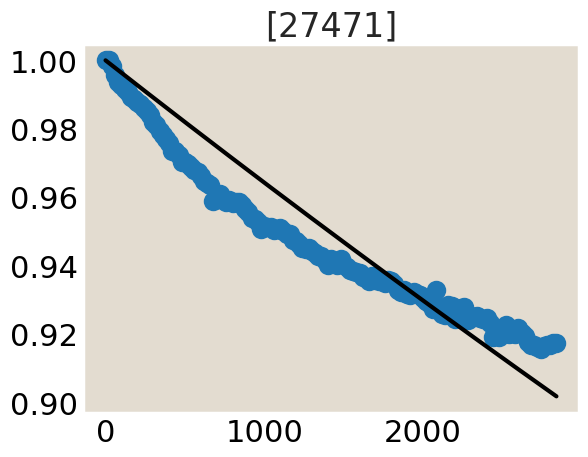

In [67]:
jkey=30
tau = singExpFit_max1(np.arange(len(motimsavg[jkey]))*20, motimsavg[jkey]/motimsavg[jkey].max(), [100]).x
plt.scatter(np.arange(len(motimsavg[jkey]))*20, motimsavg[jkey]/motimsavg[jkey].max())
plt.plot(np.arange(len(motimsavg[jkey]))*20, singExp_max1(np.arange(len(motimsavg[jkey]))*20, tau), c='k')
plt.title([round(tau[0])])

Text(0.5, 1.0, '[1433, np.float64(0.91)]')

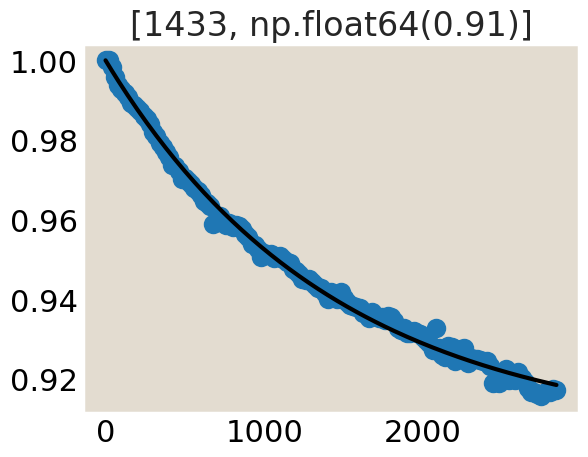

In [59]:
jkey=30
tau, Iinf = singExpConstFit_max1(np.arange(len(motimsavg[jkey]))*20, motimsavg[jkey]/motimsavg[jkey].max(), [100, 0.8]).x
plt.scatter(np.arange(len(motimsavg[jkey]))*20, motimsavg[jkey]/motimsavg[jkey].max())
plt.plot(np.arange(len(motimsavg[jkey]))*20, singExpConst_max1(np.arange(len(motimsavg[jkey]))*20, [tau, Iinf]), c='k')
plt.title([round(tau), round(Iinf,2)])

/tmp/ipykernel_2392981/959584945.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10,10))


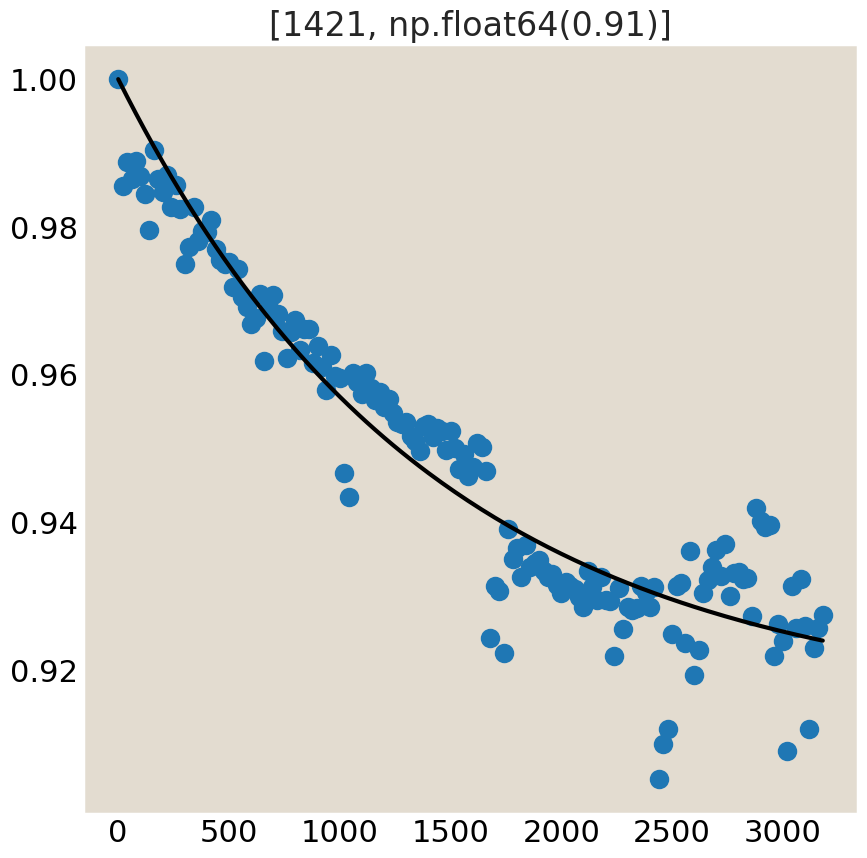

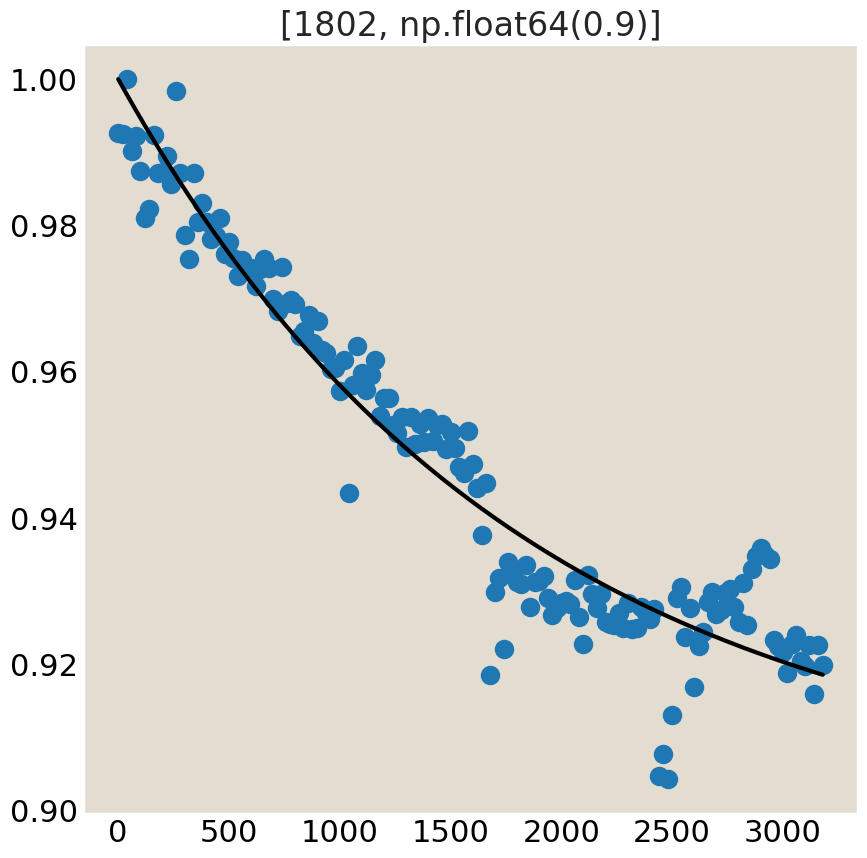

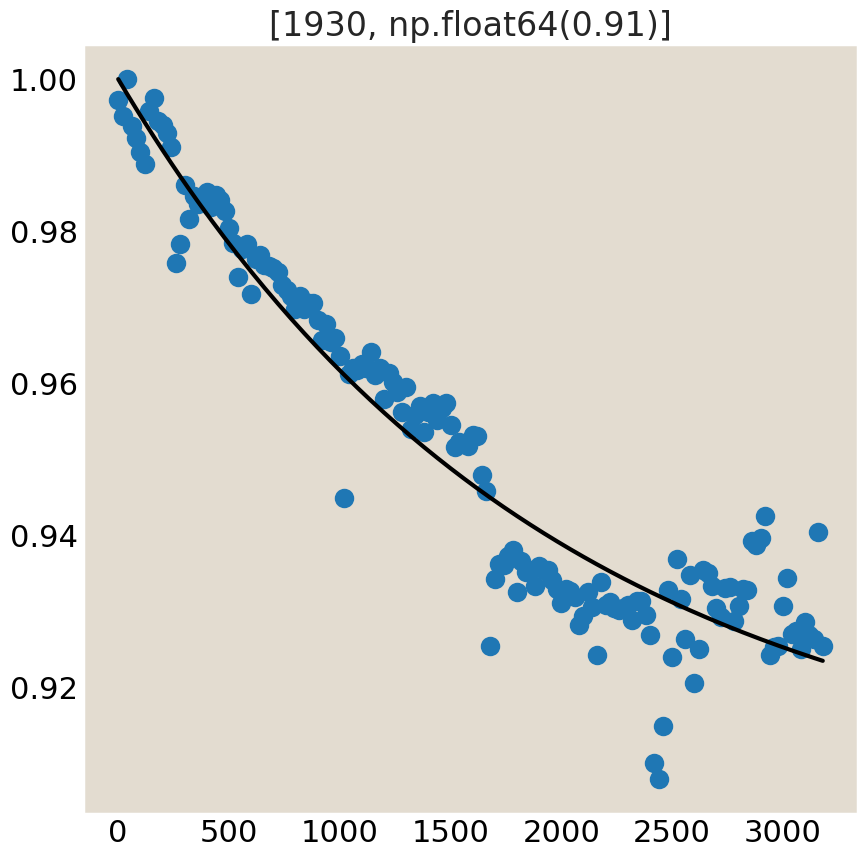

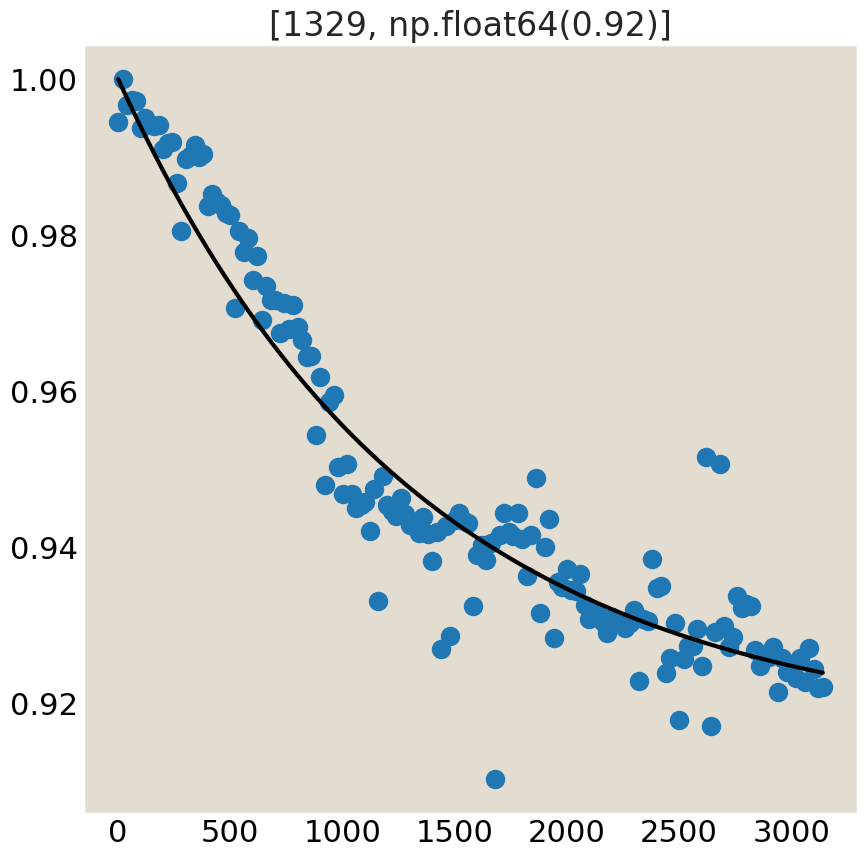

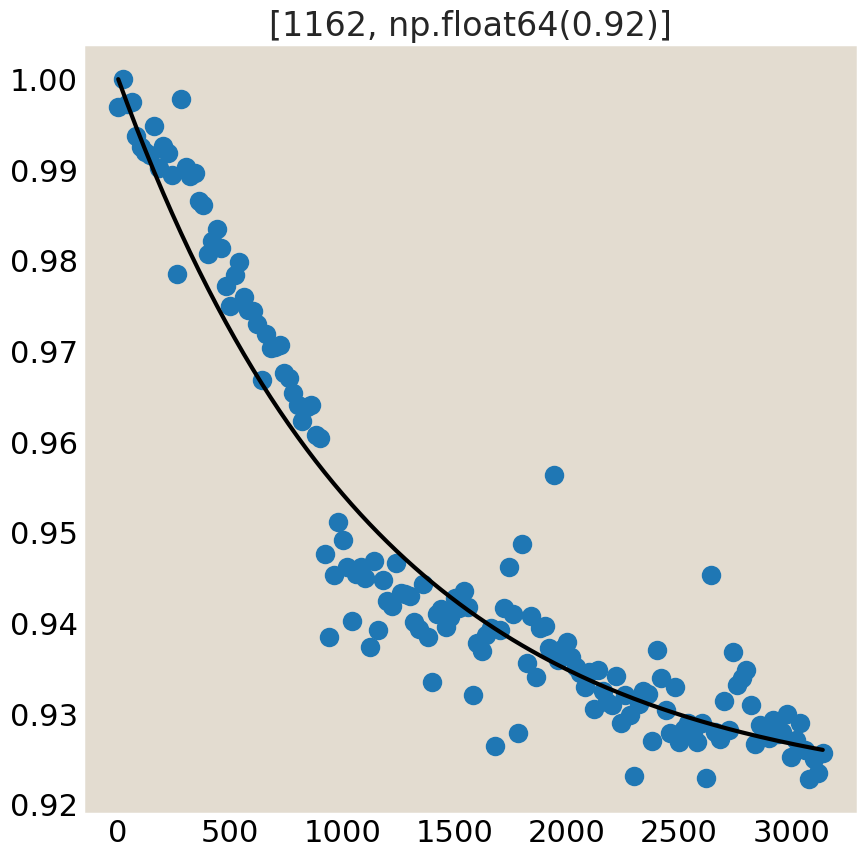

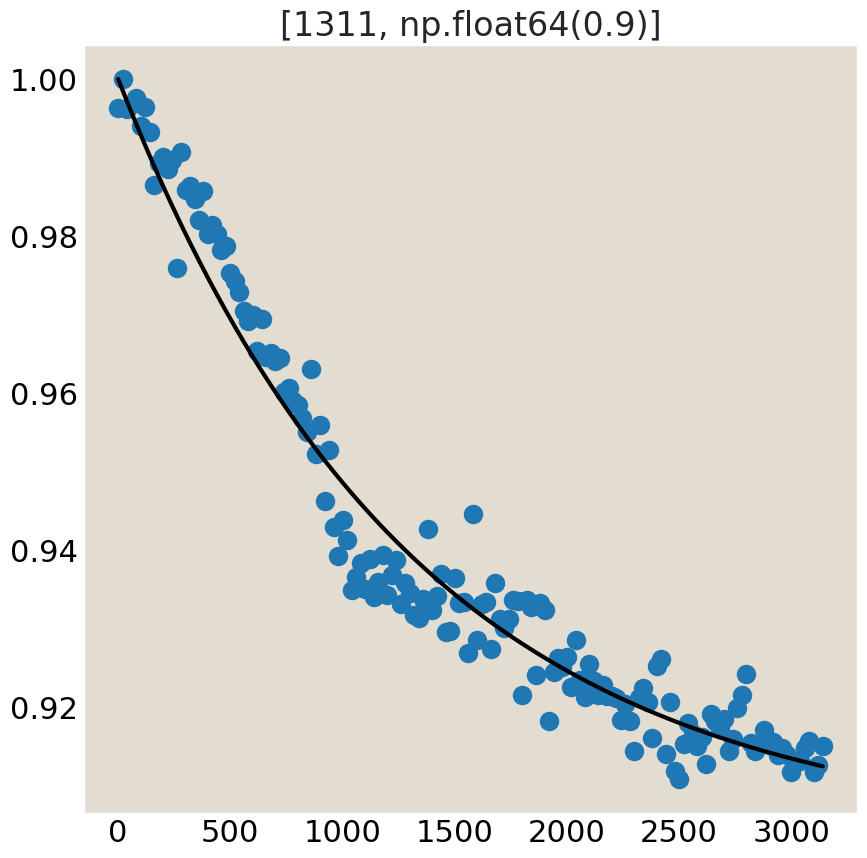

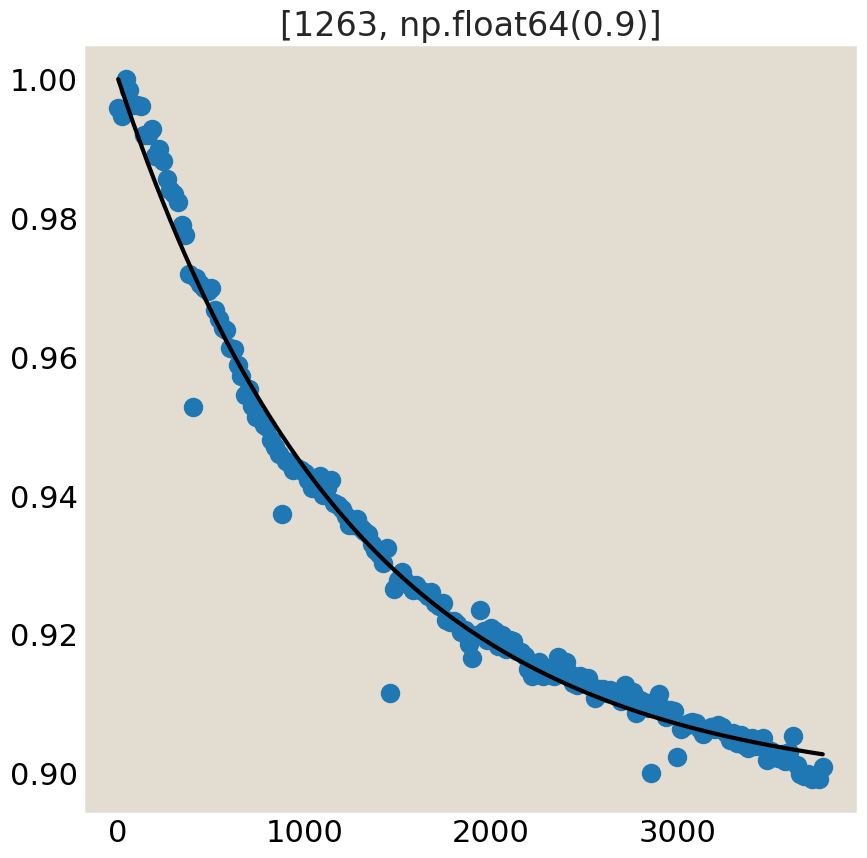

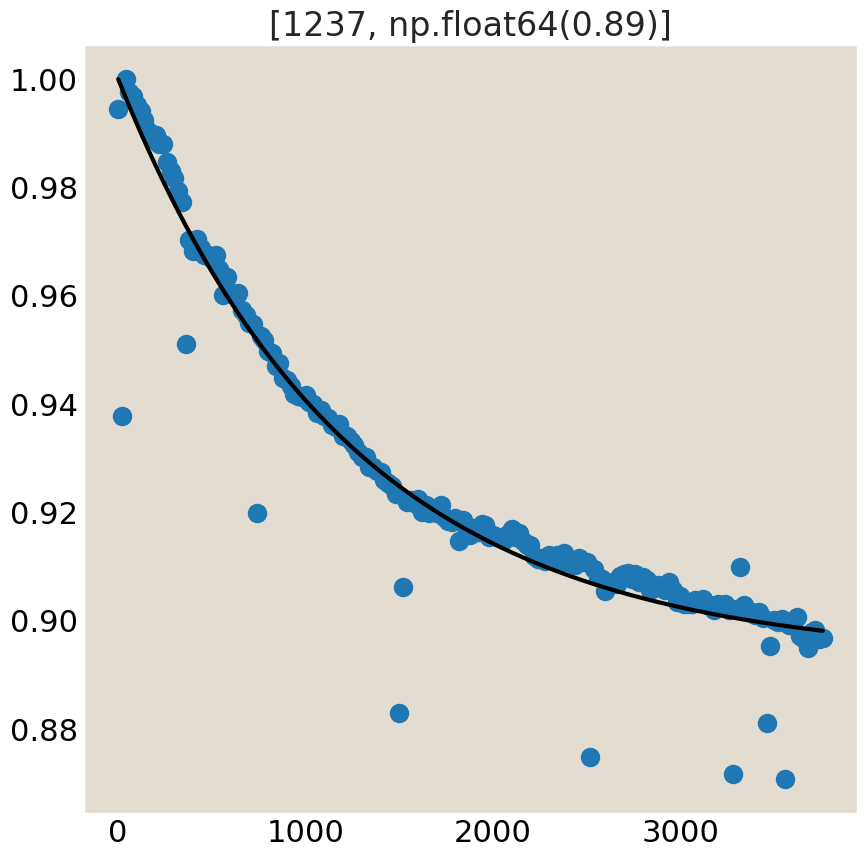

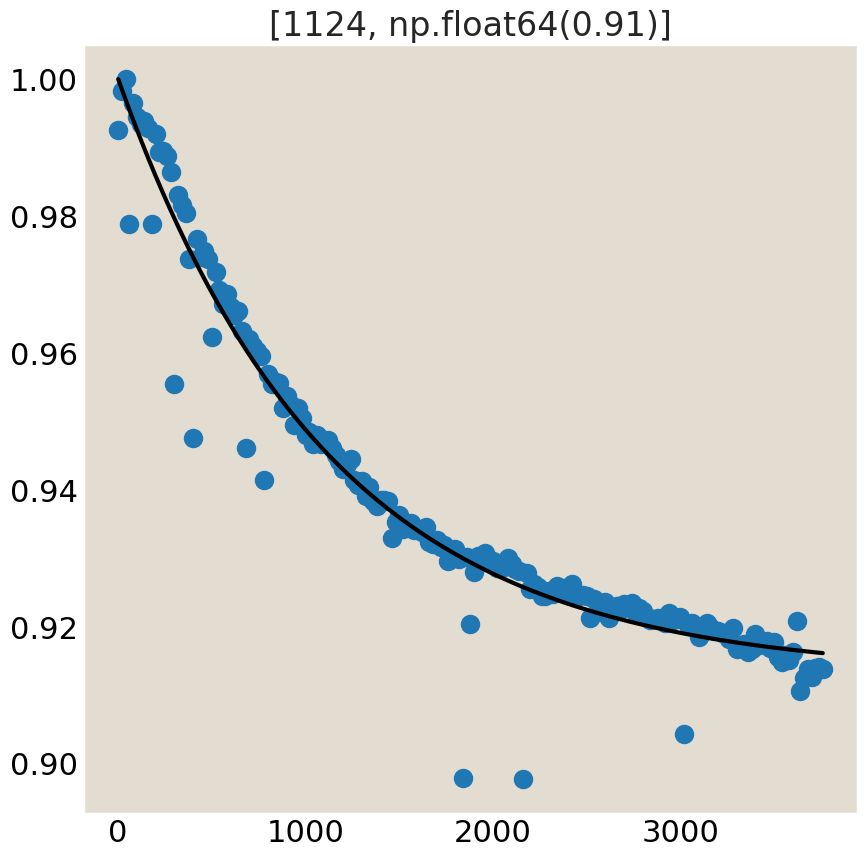

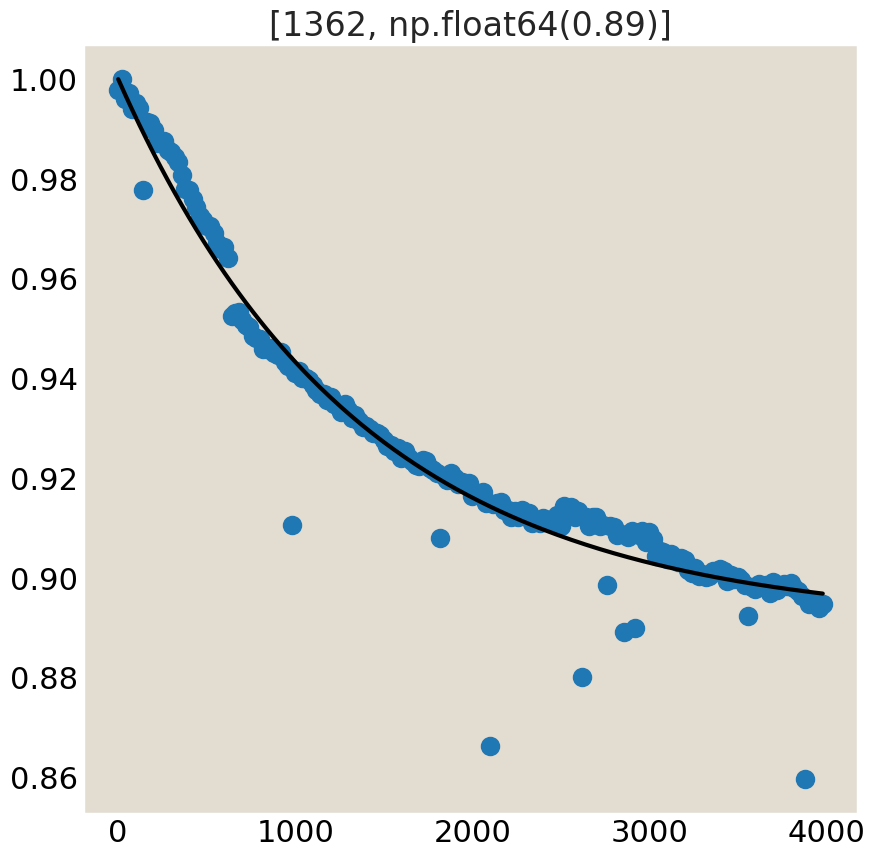

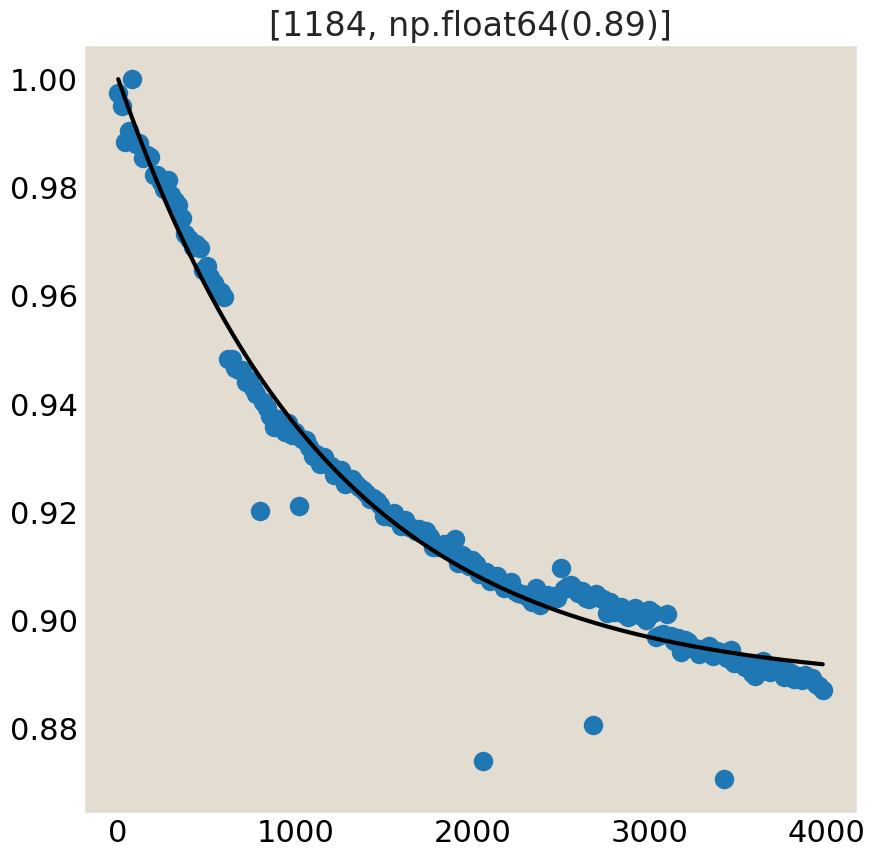

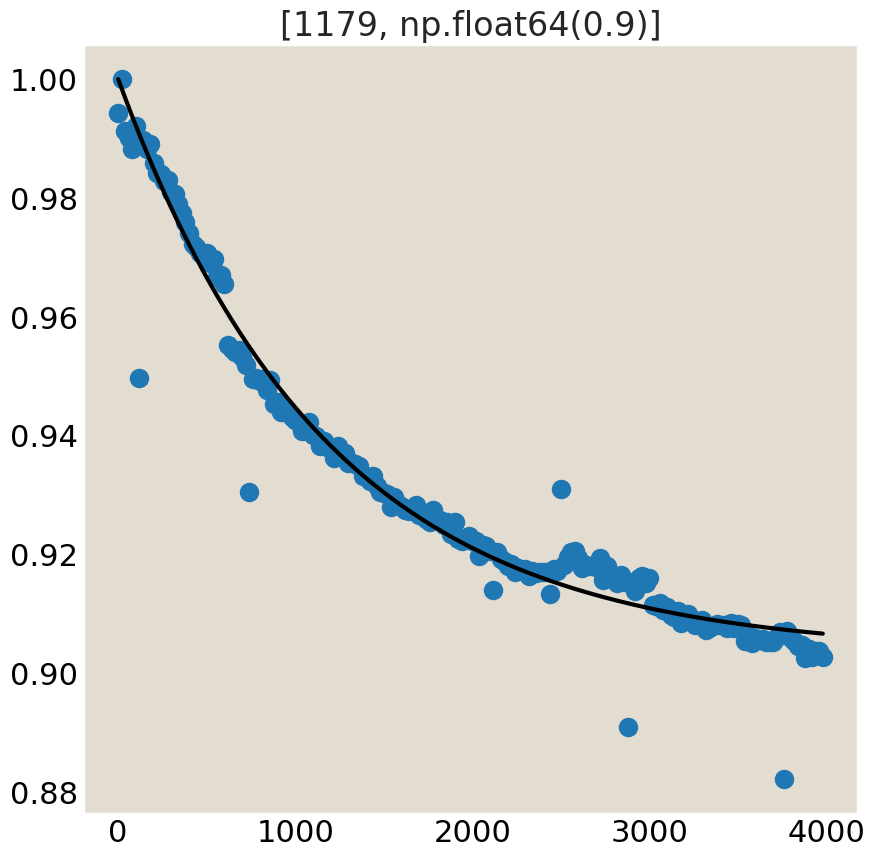

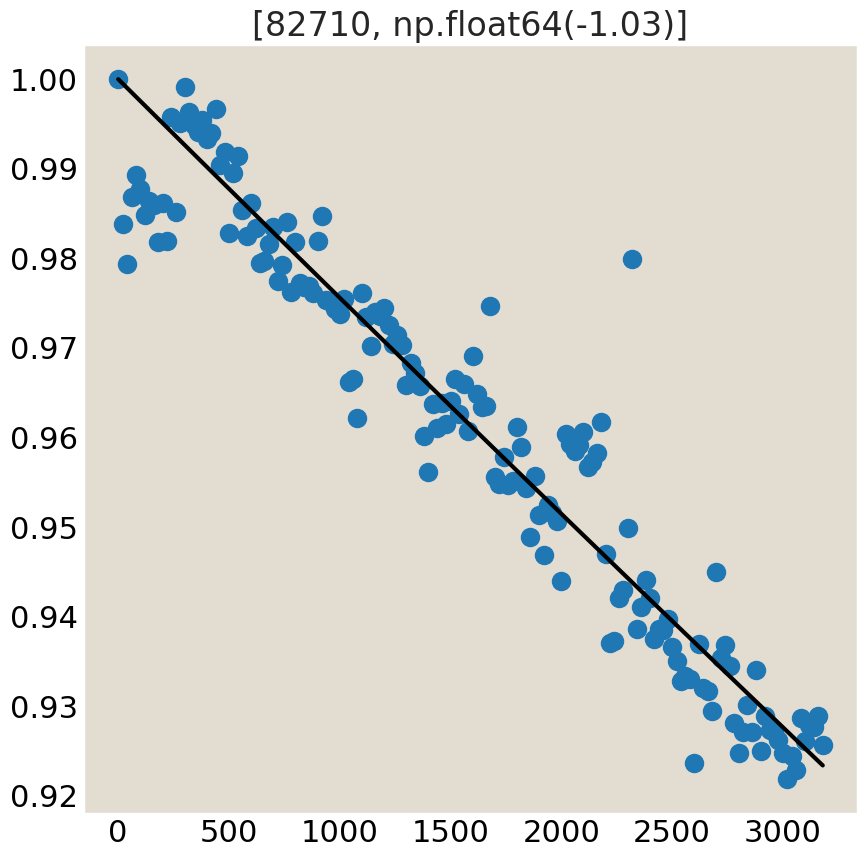

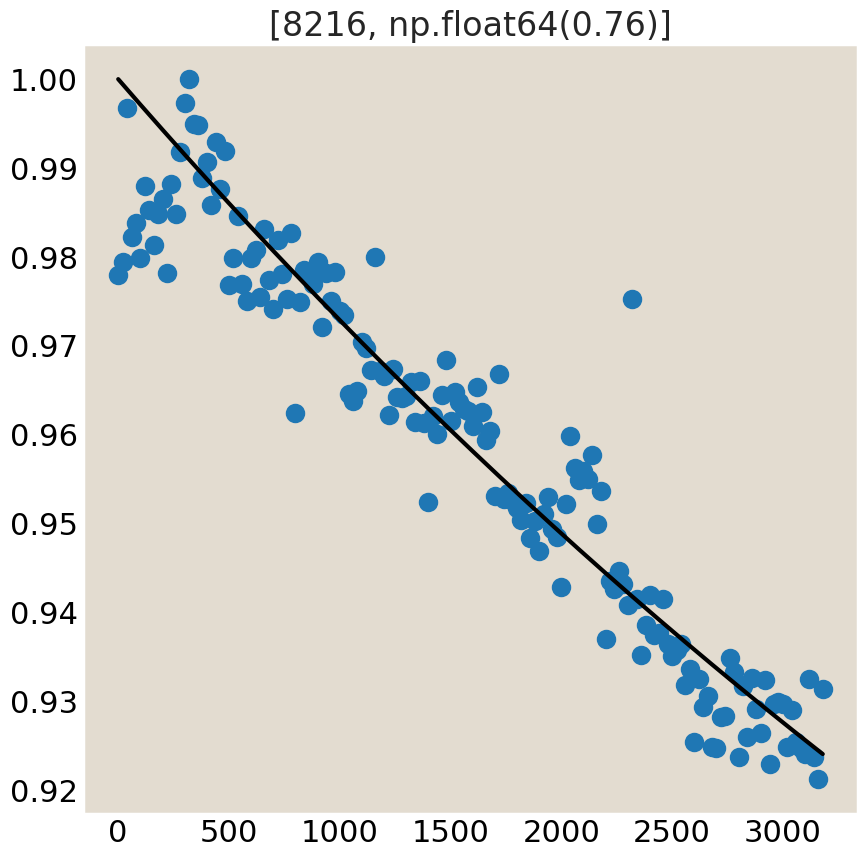

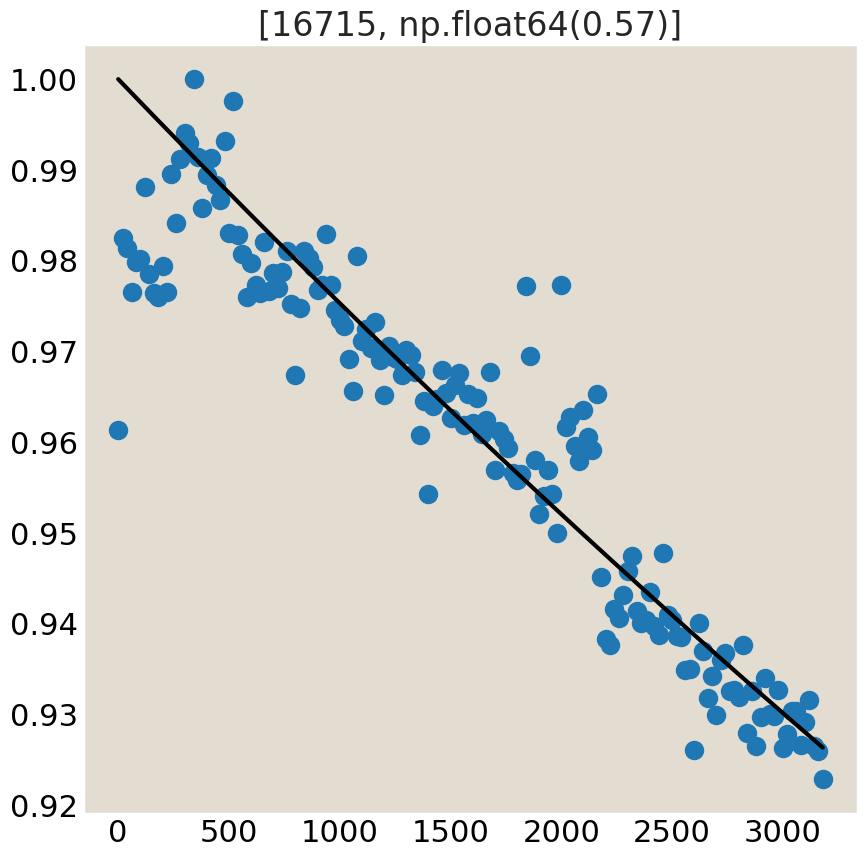

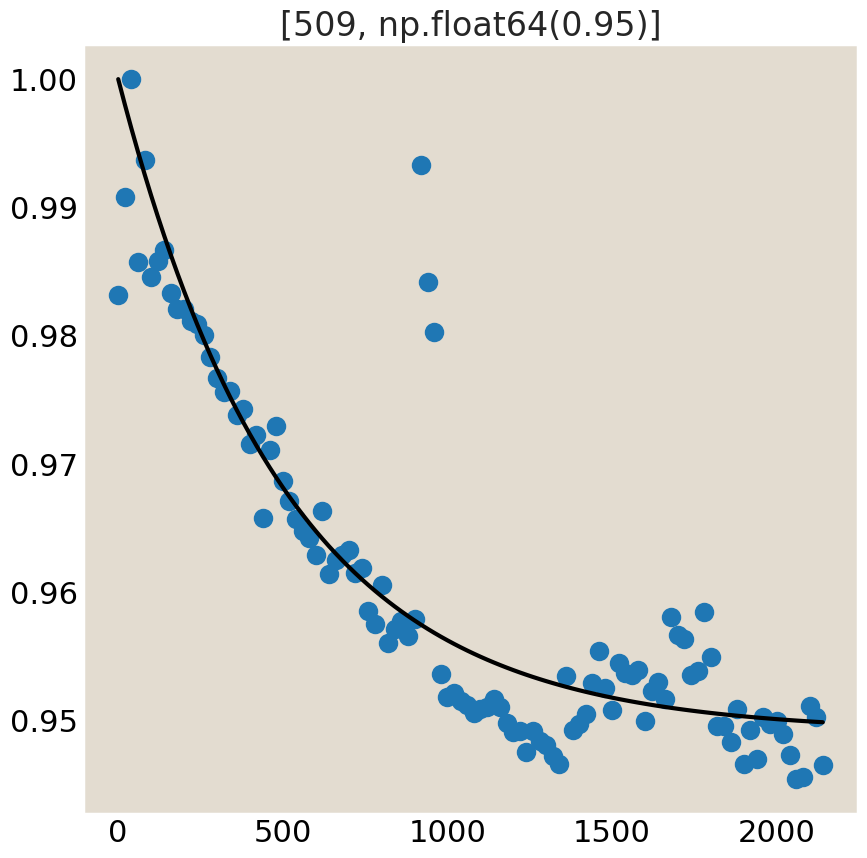

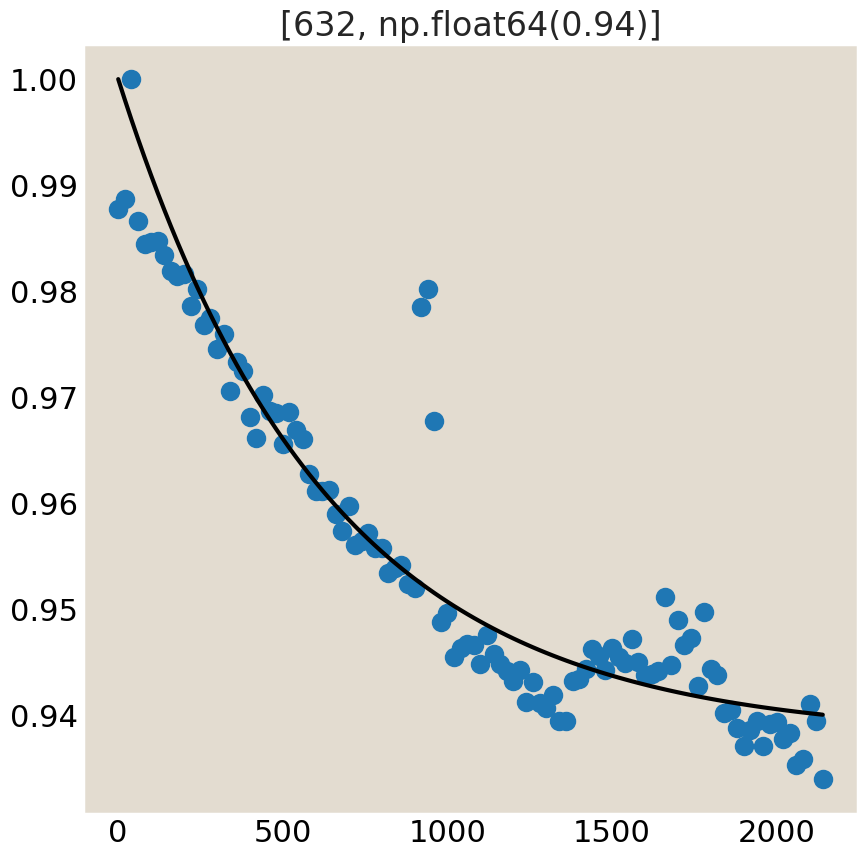

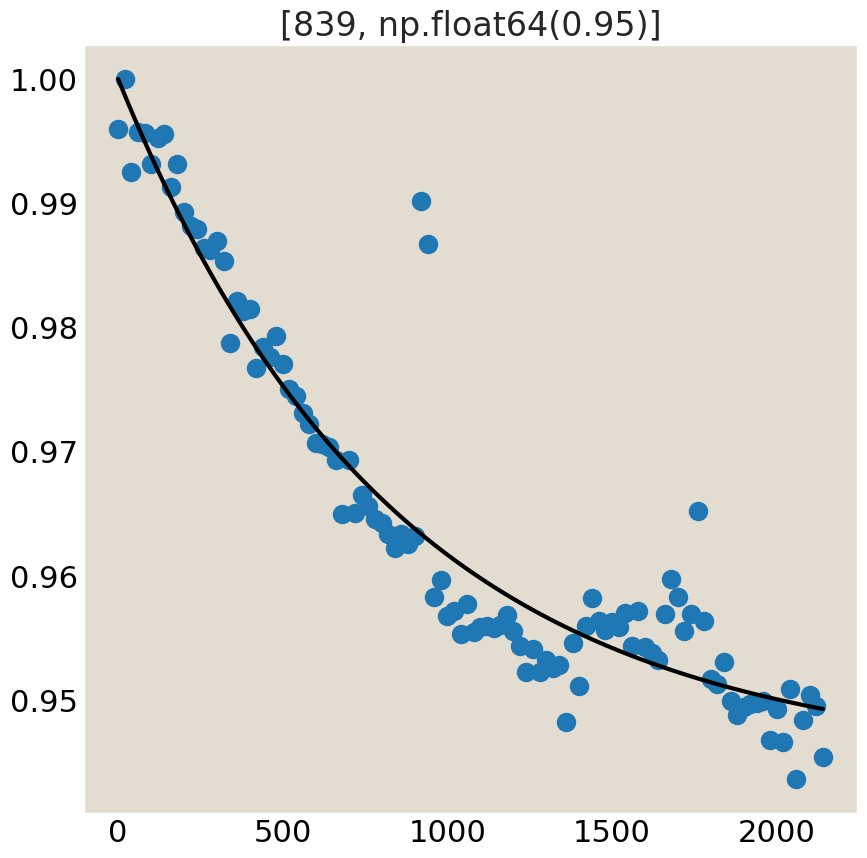

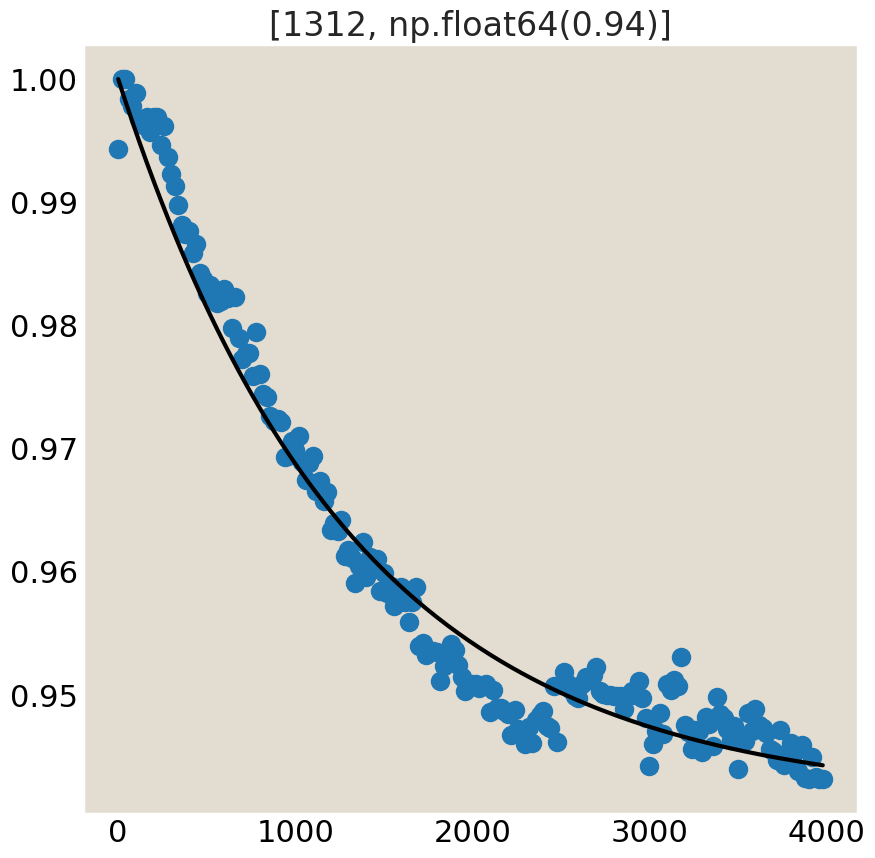

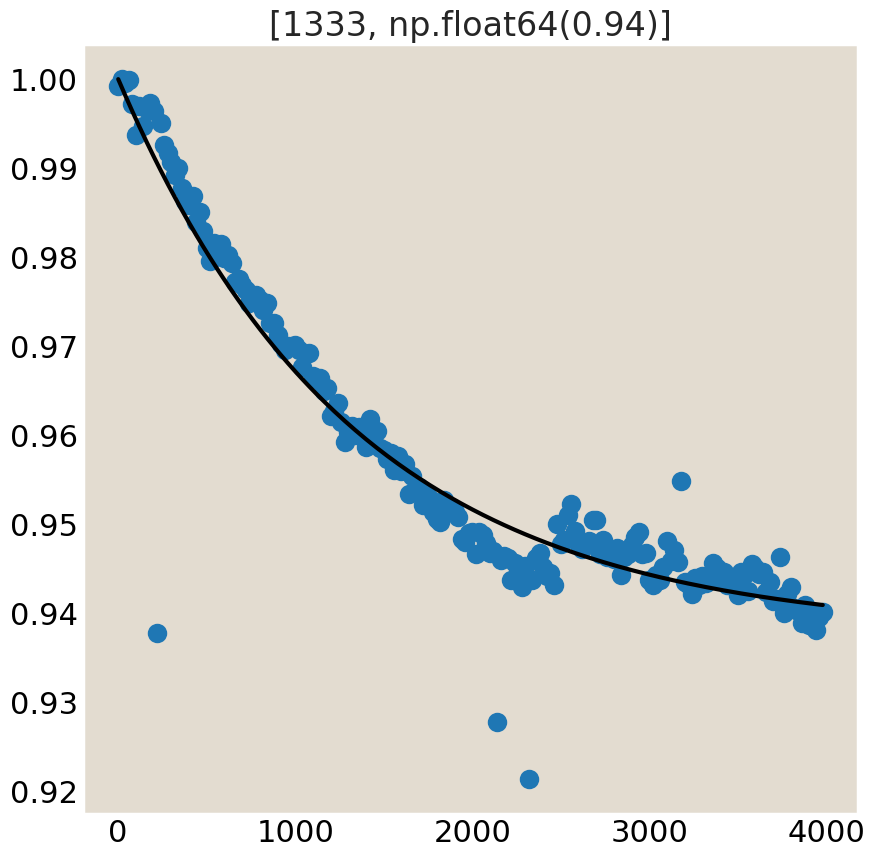

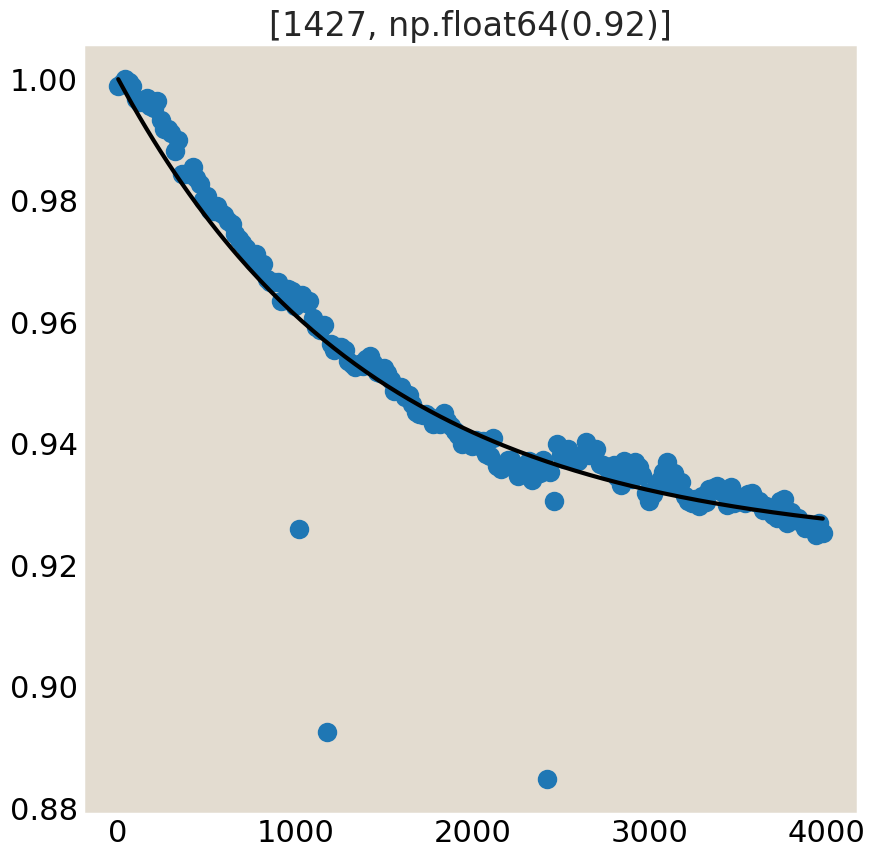

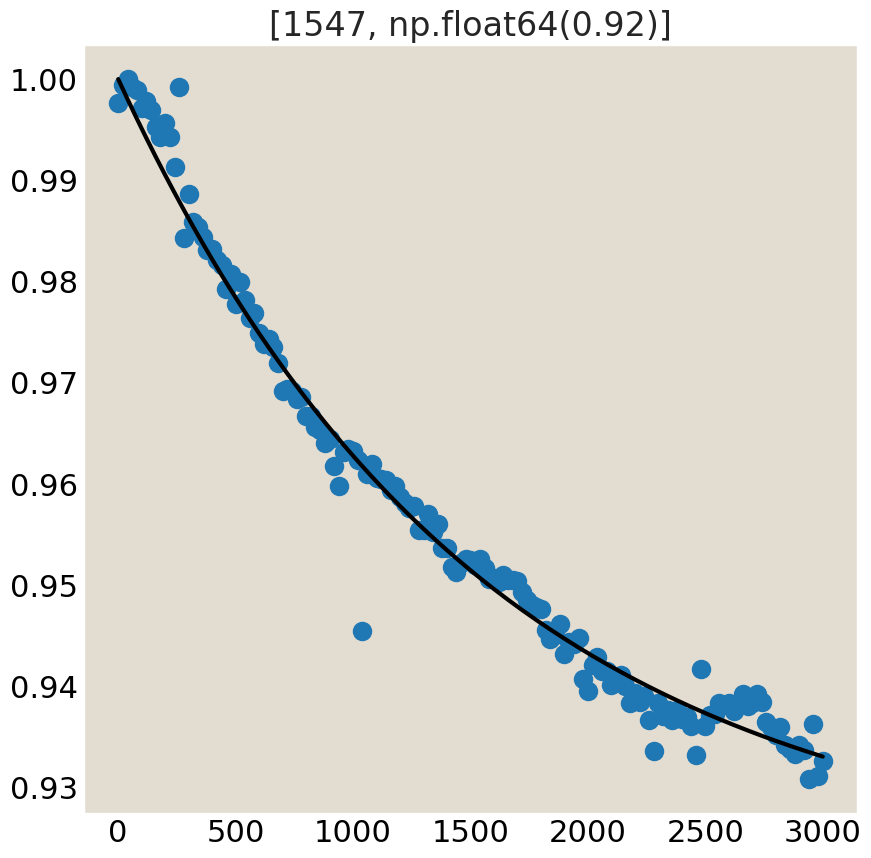

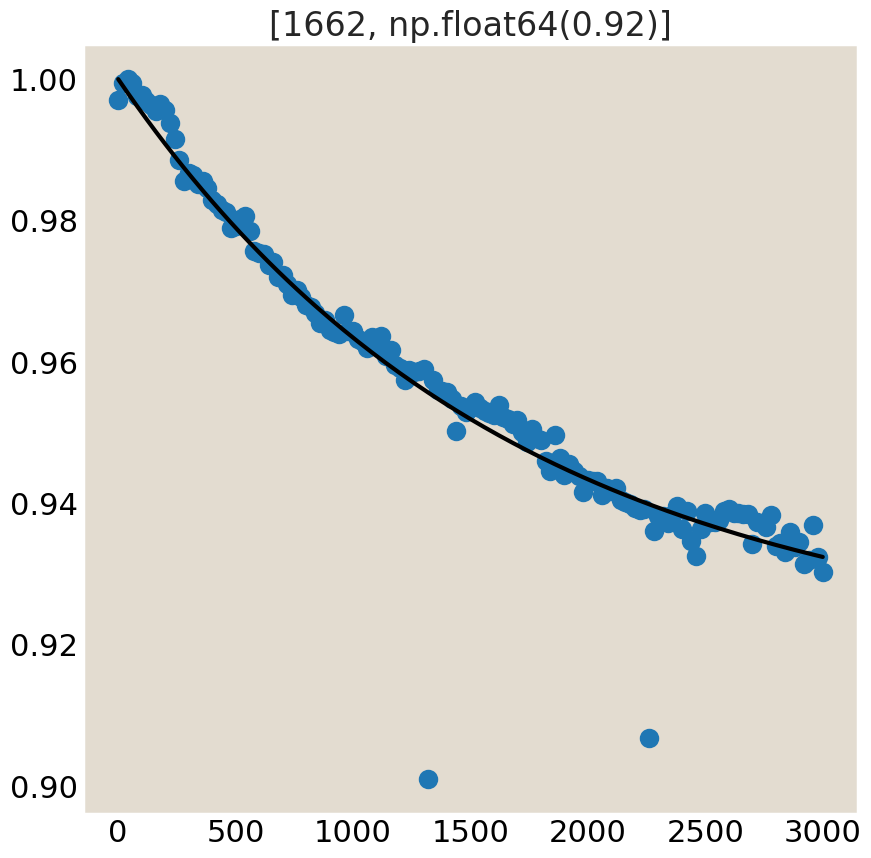

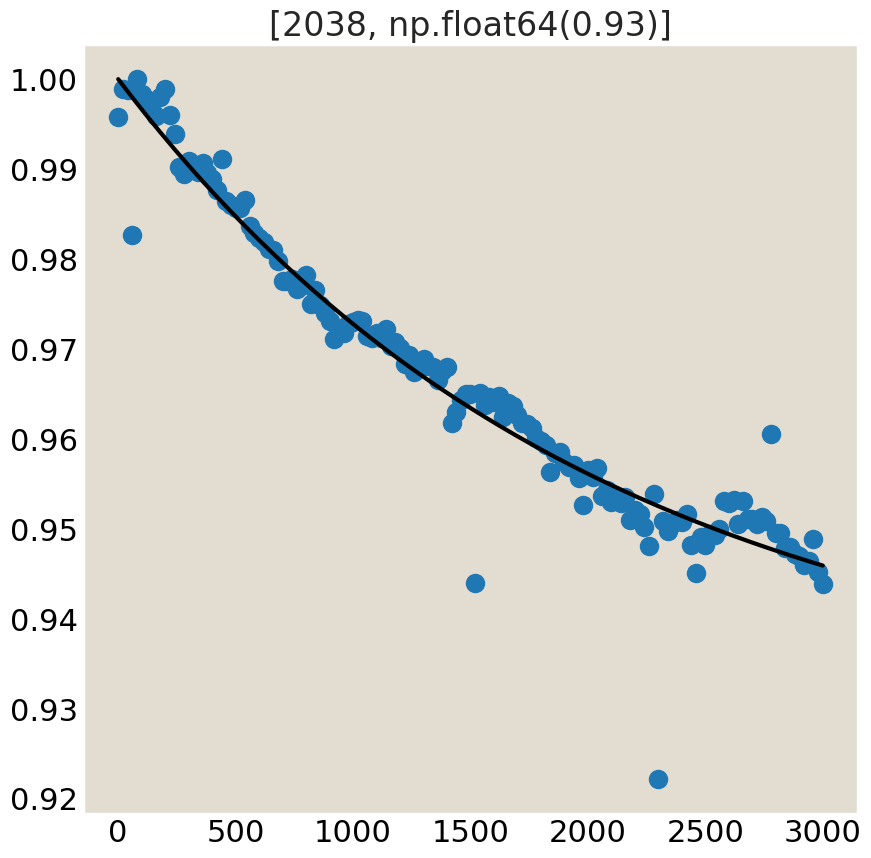

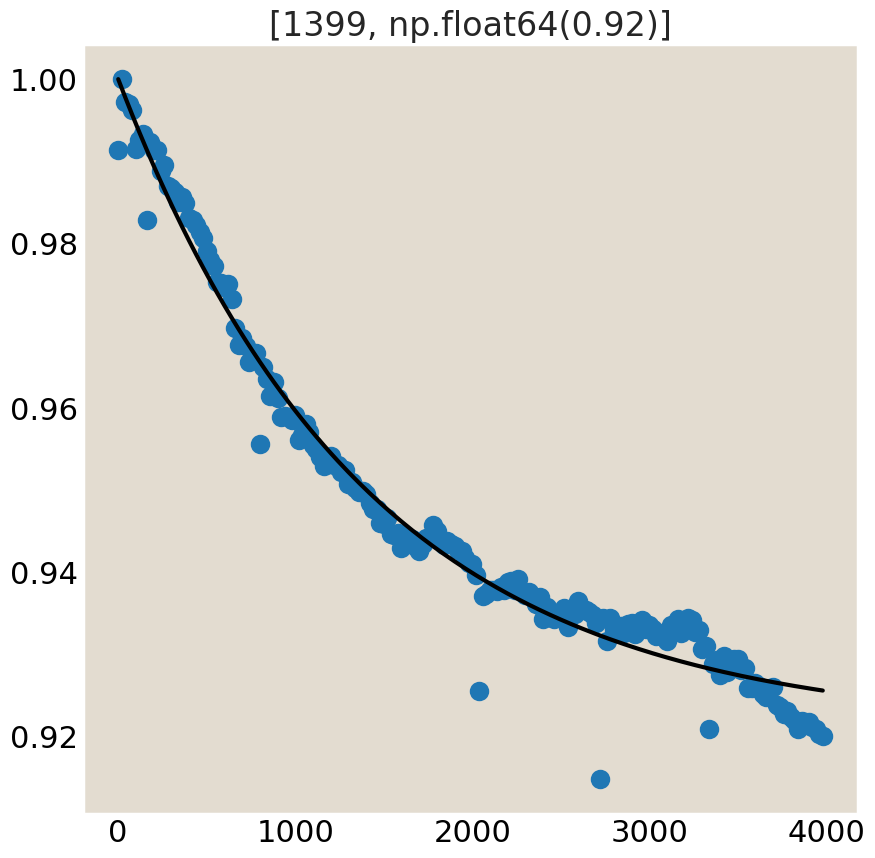

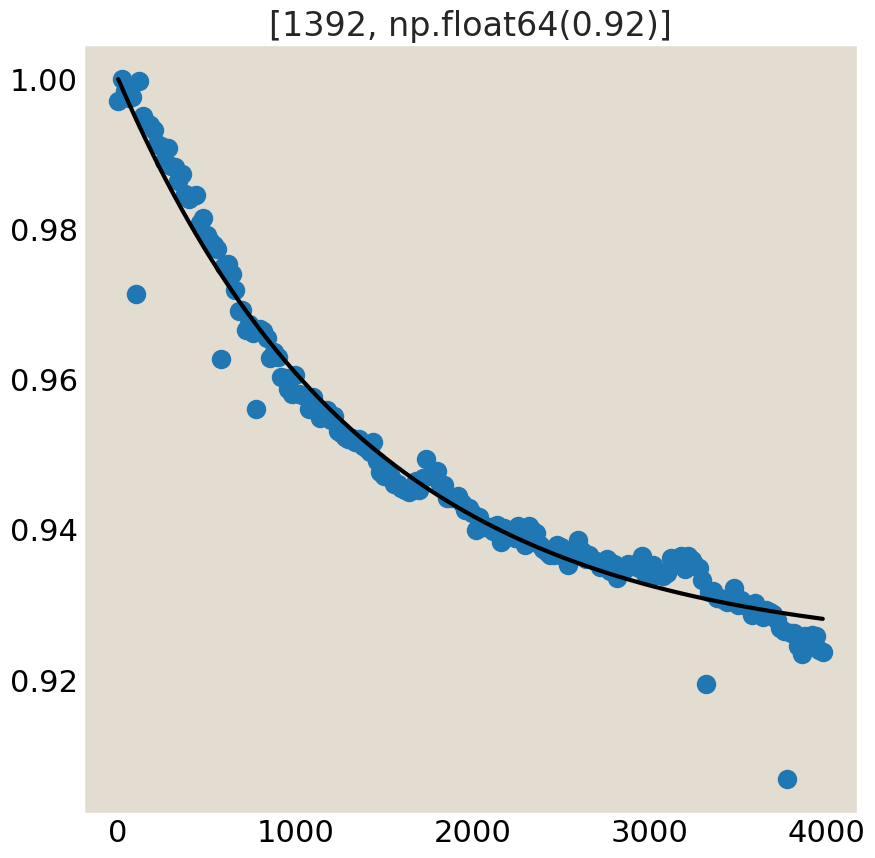

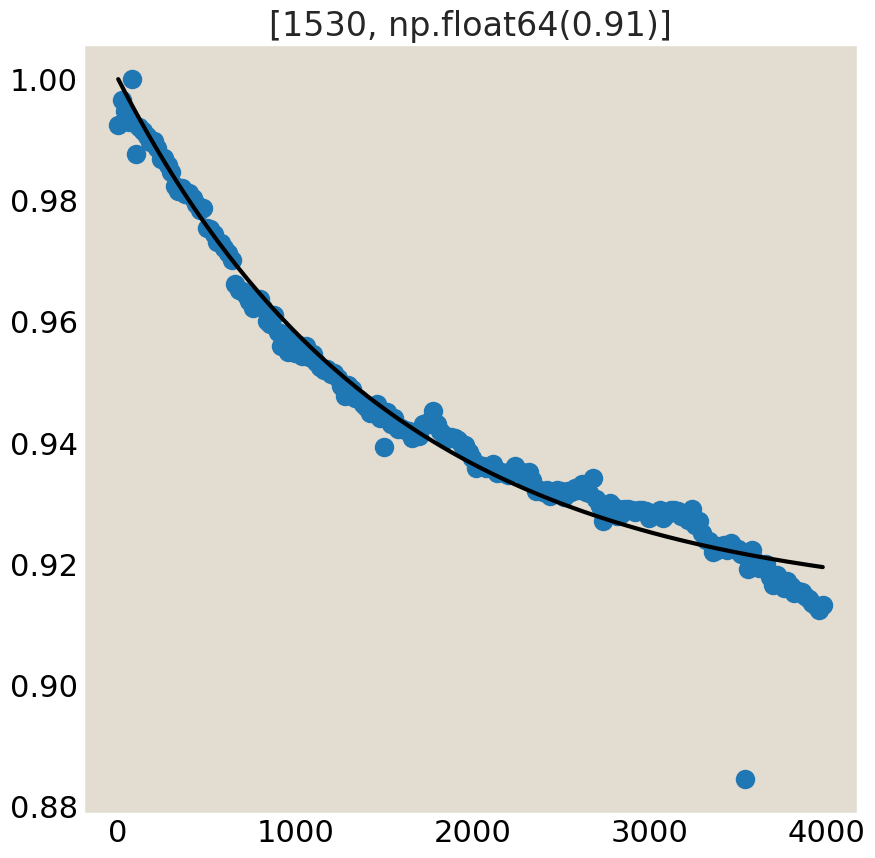

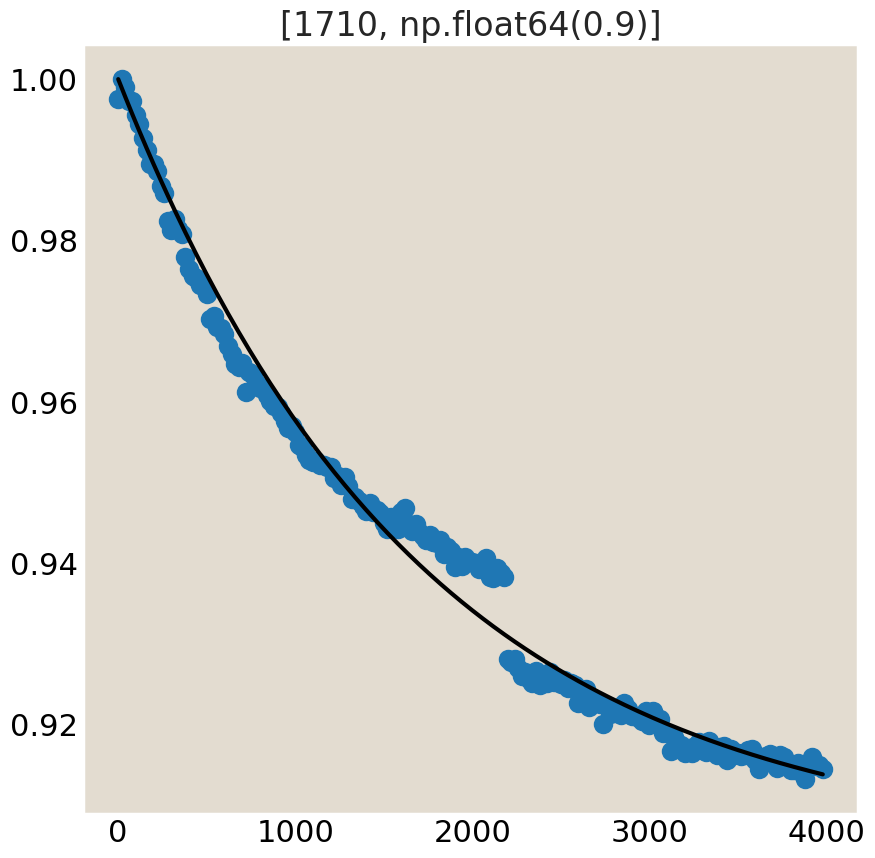

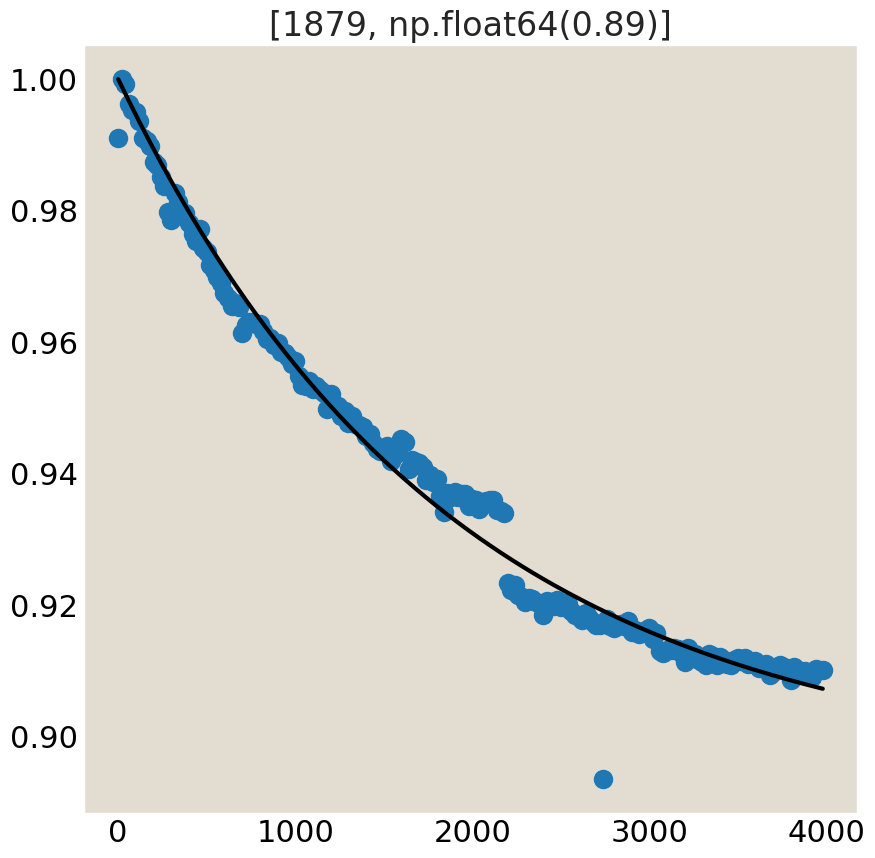

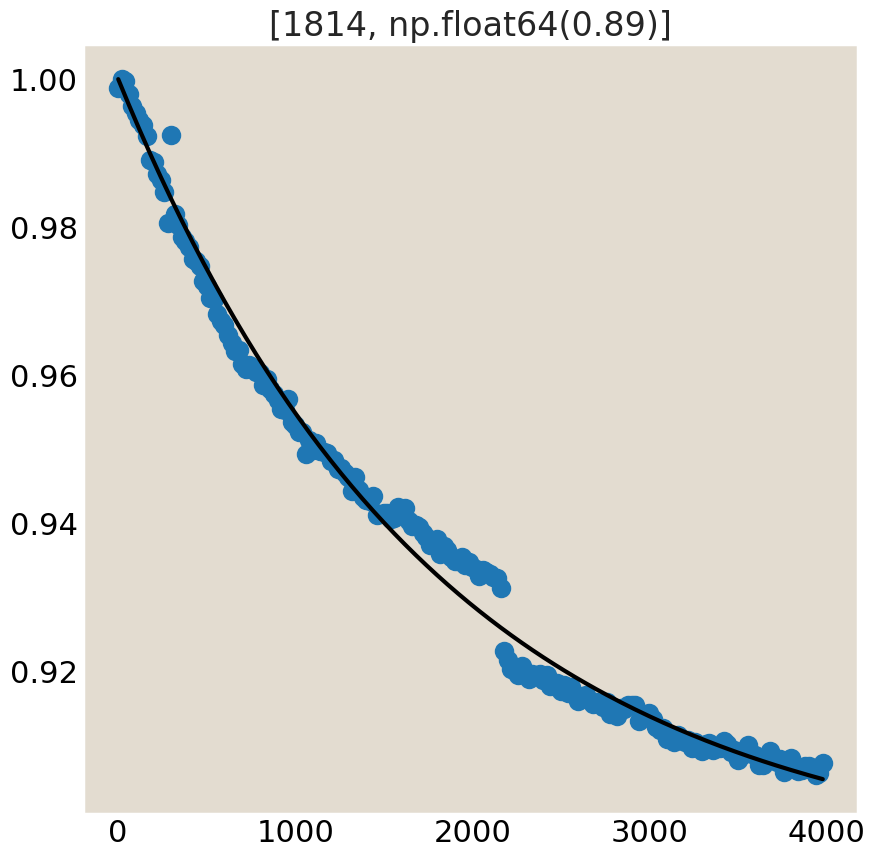

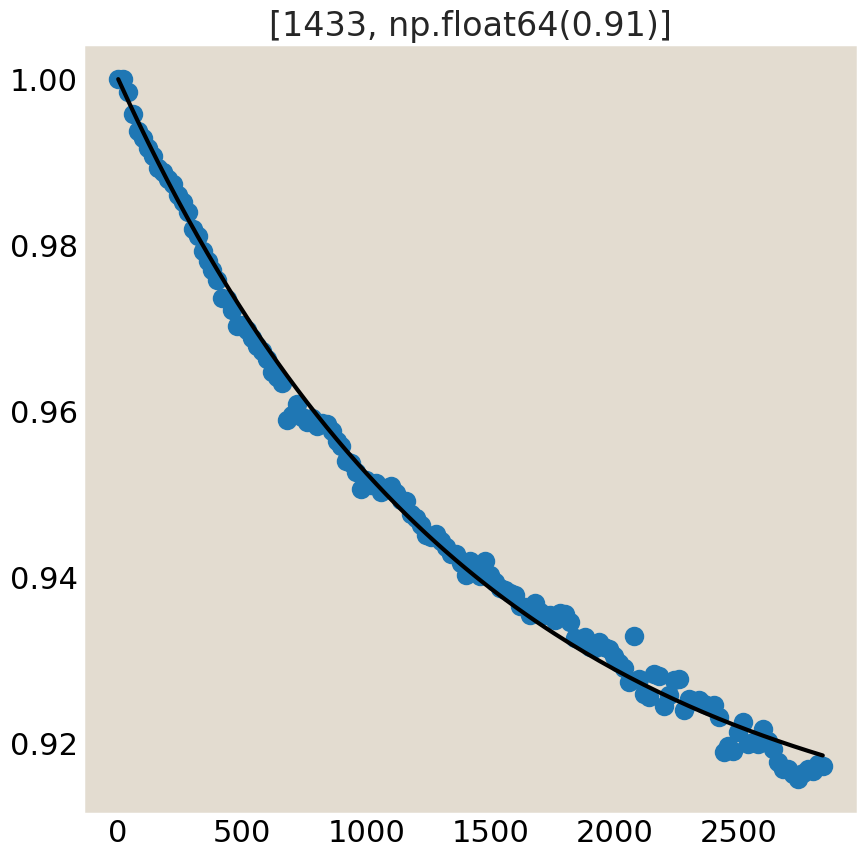

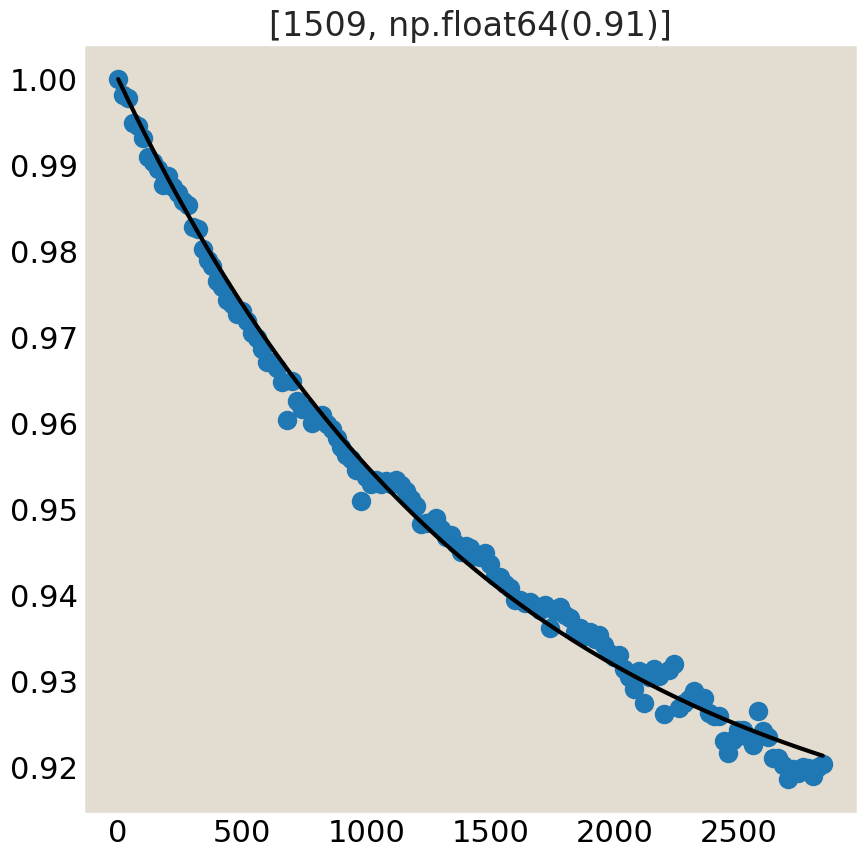

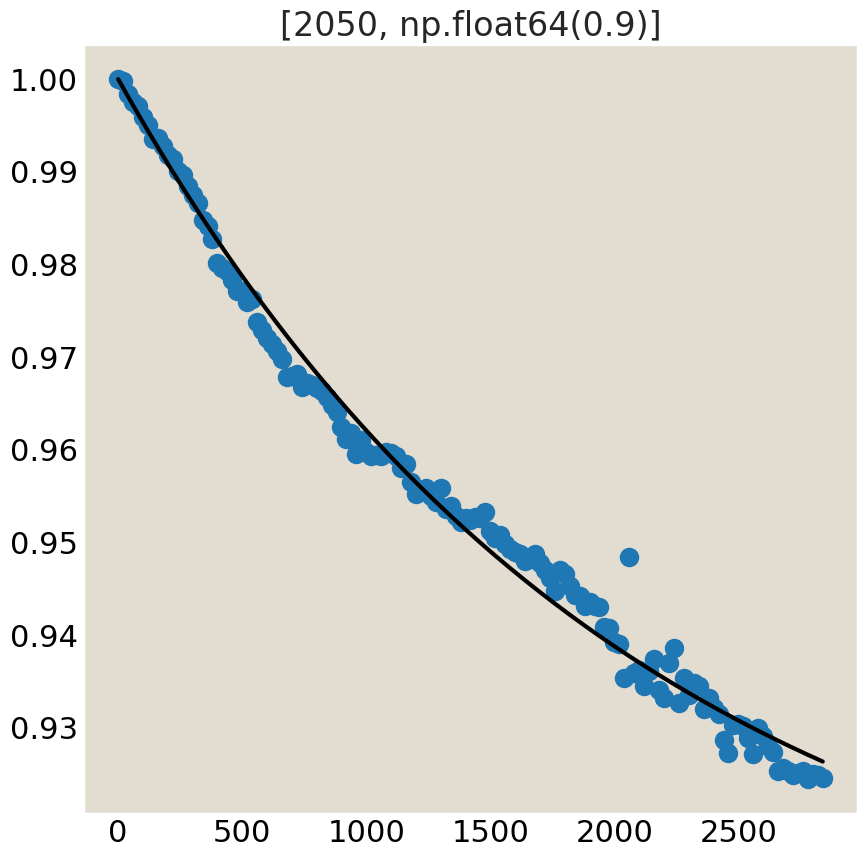

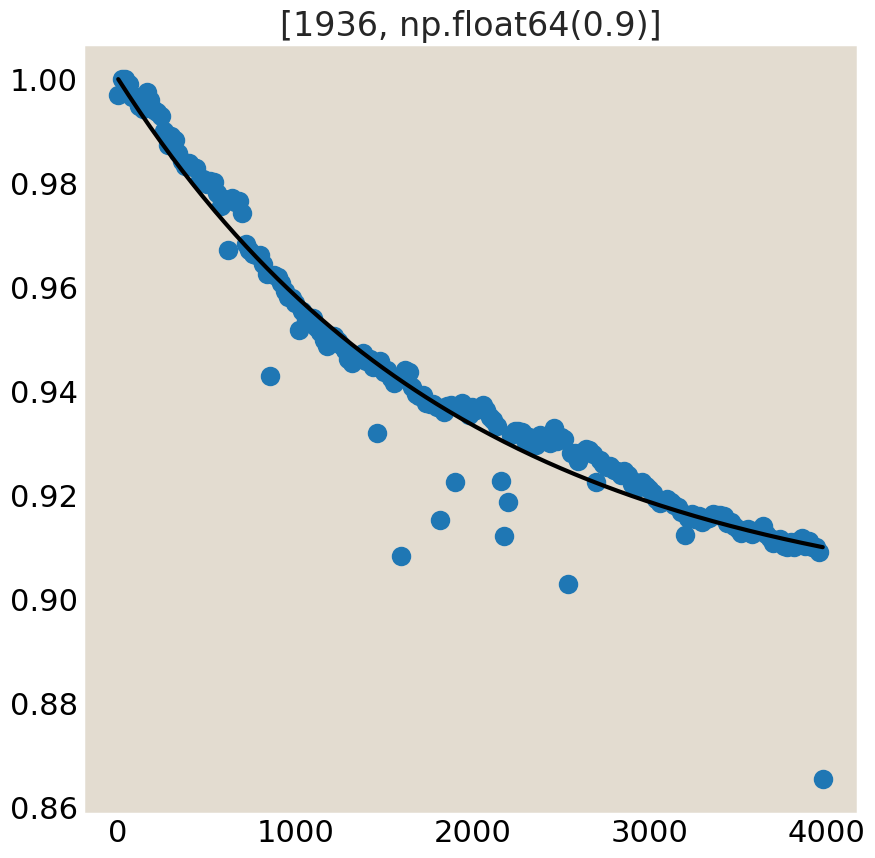

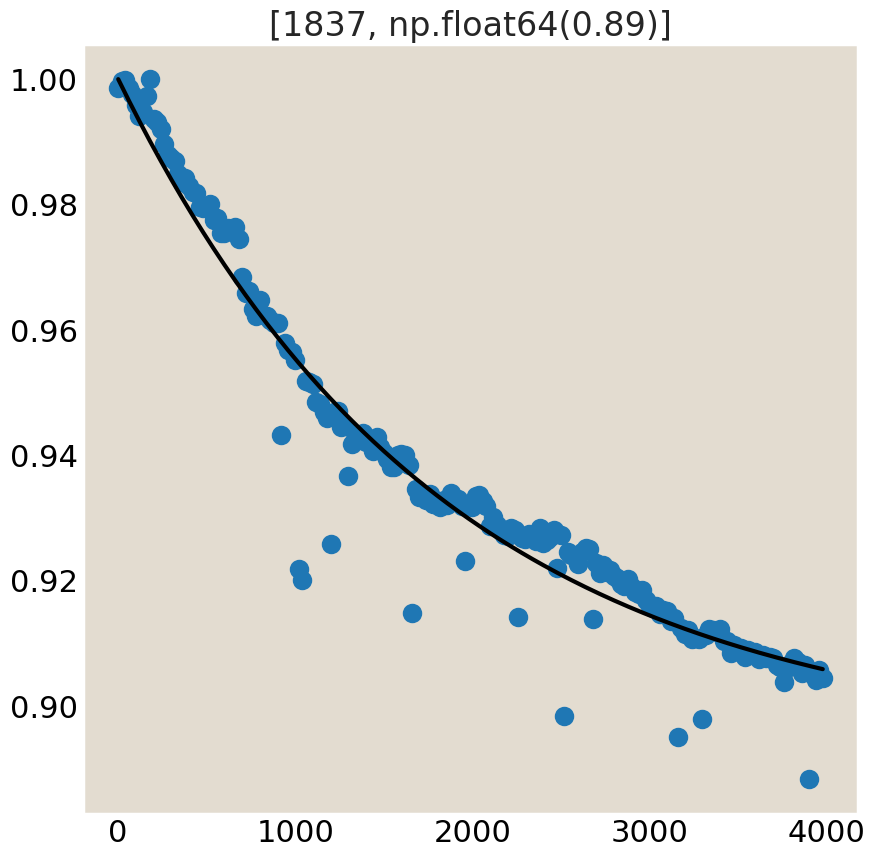

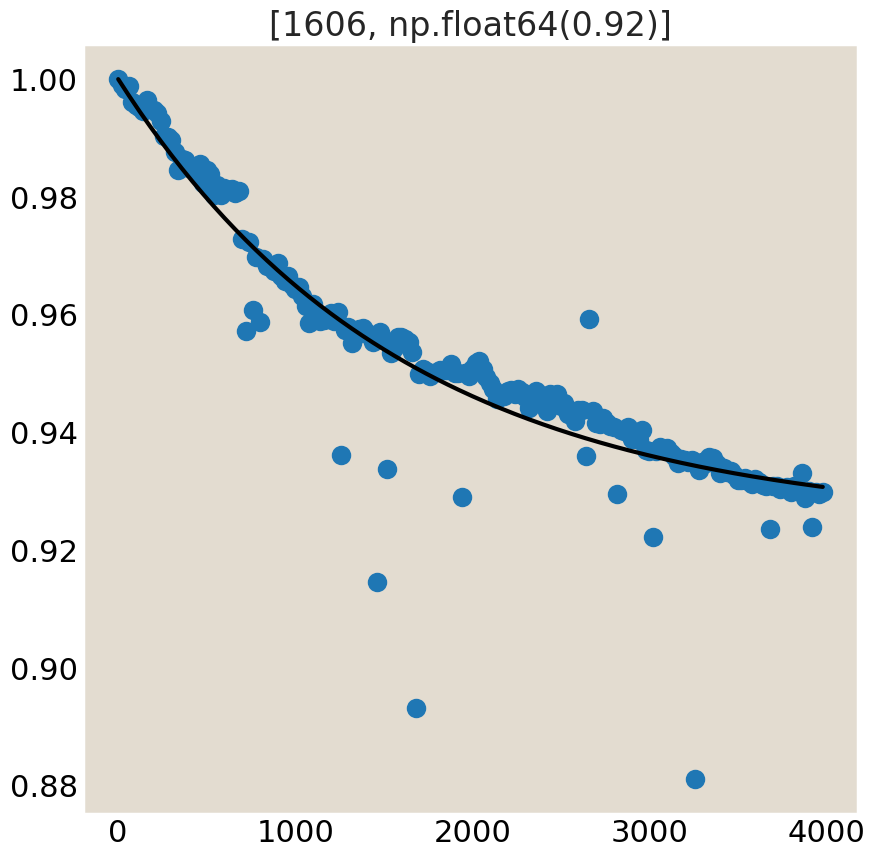

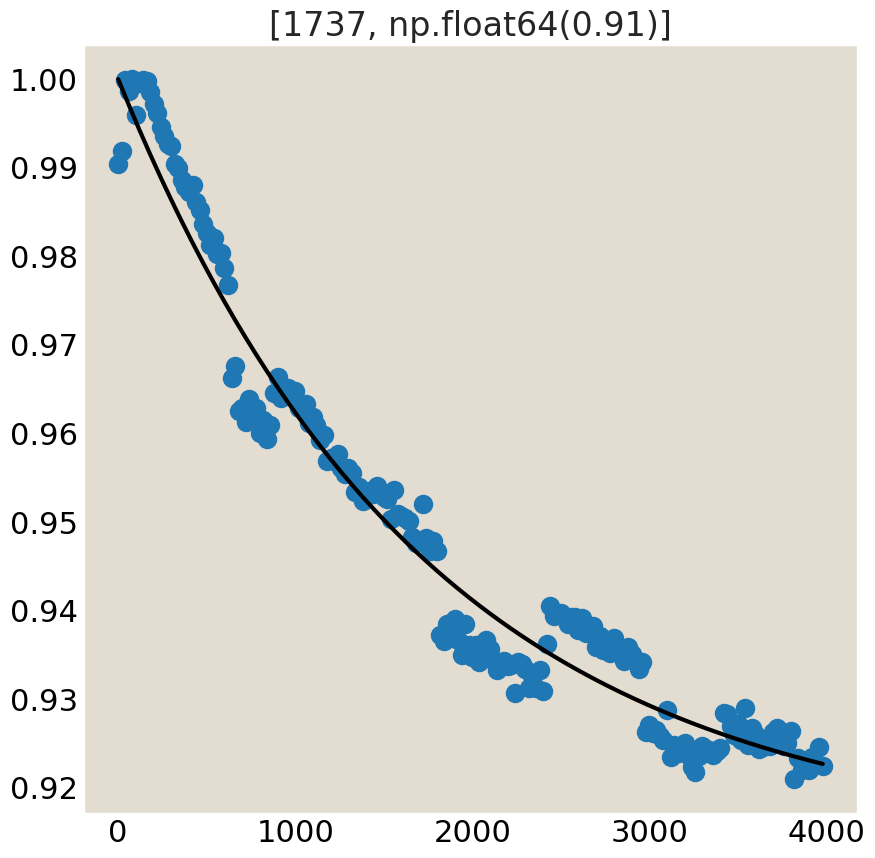

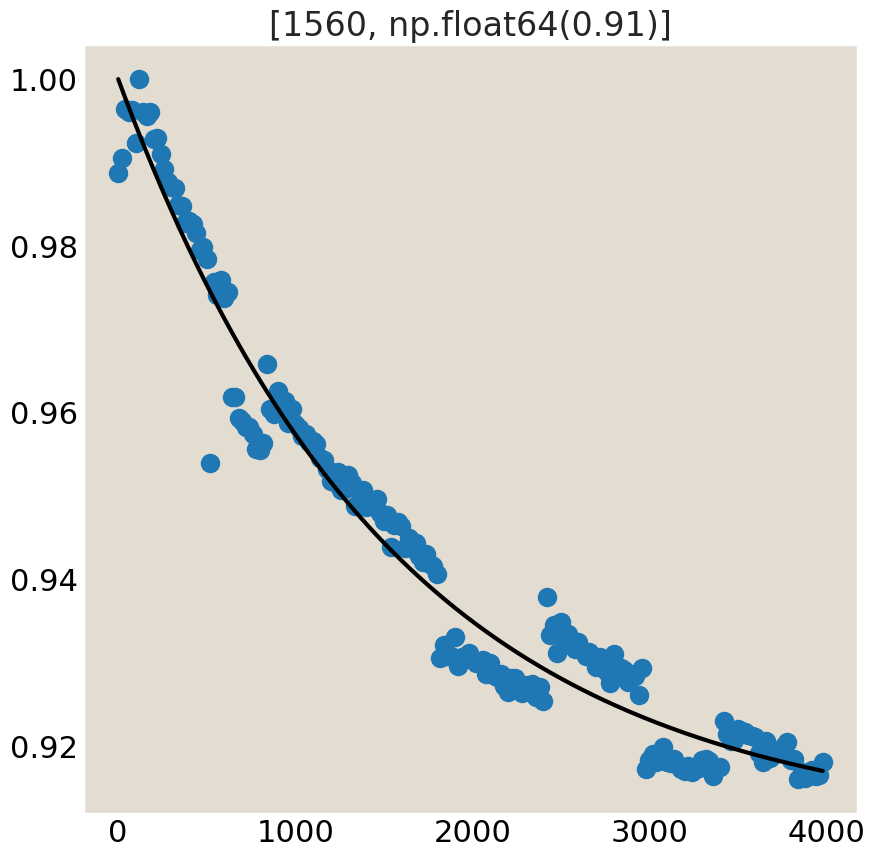

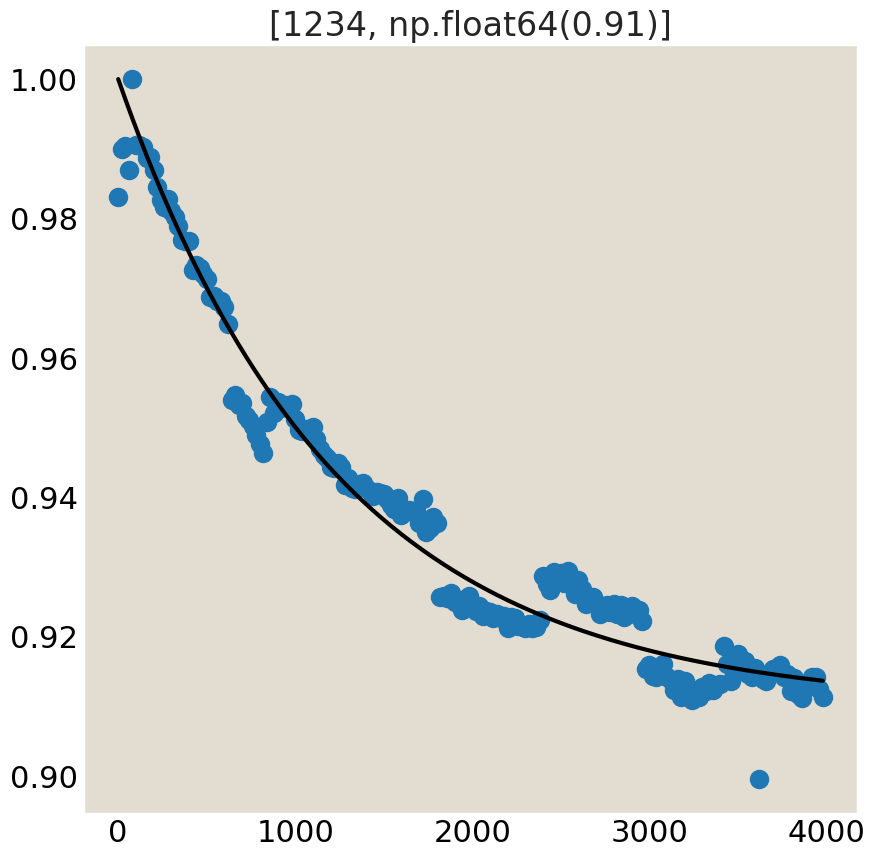

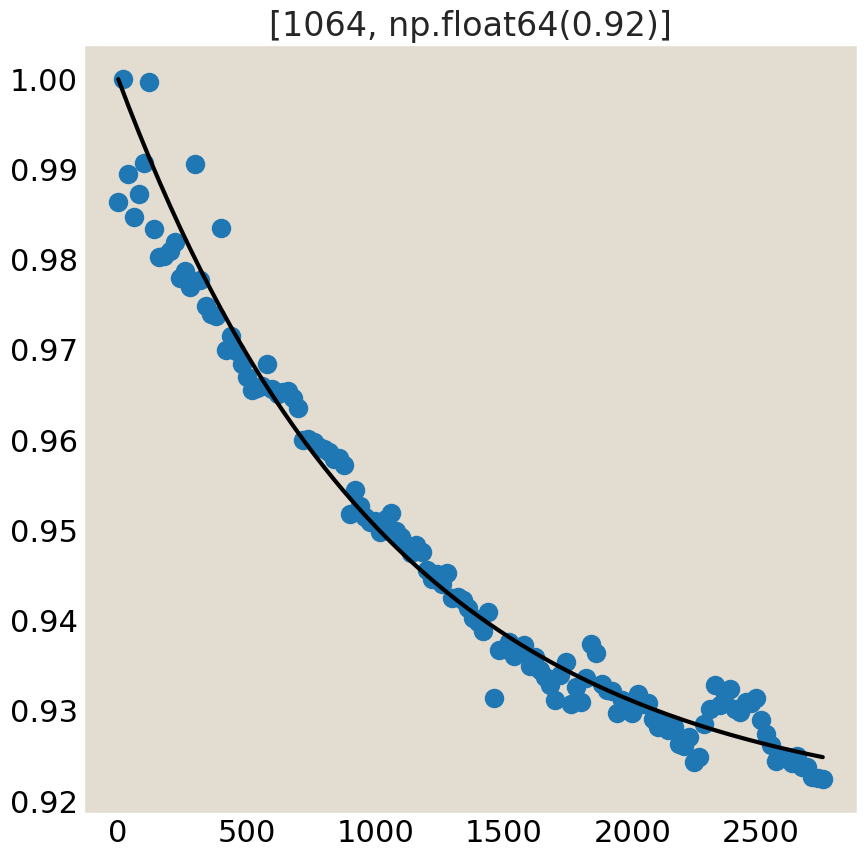

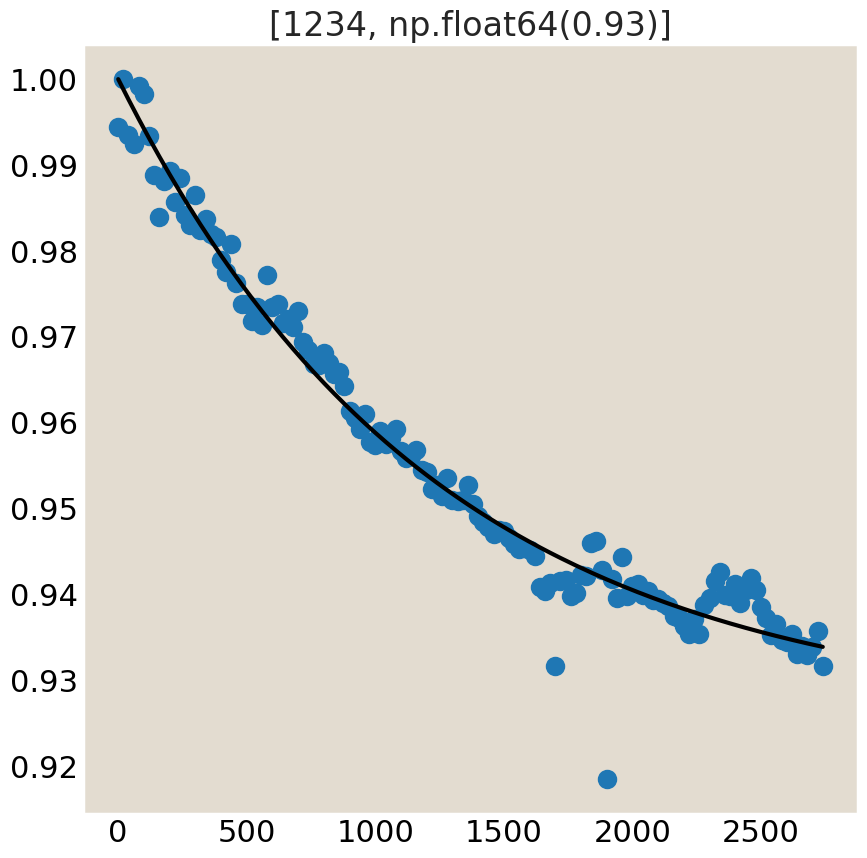

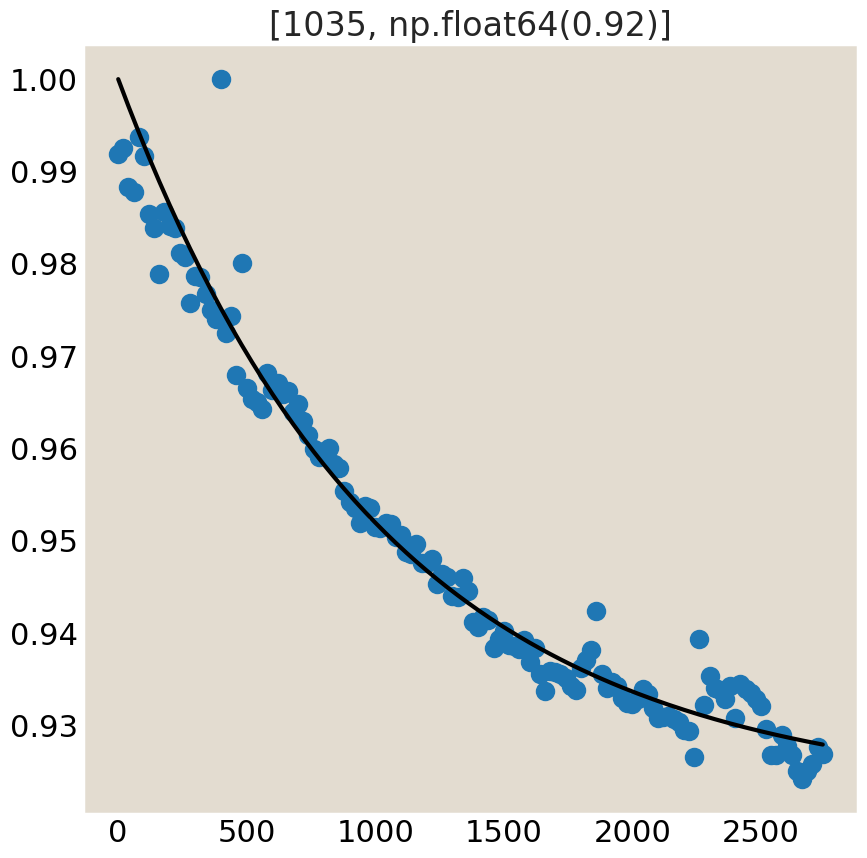

In [72]:
motimsavgfit = []
for jkey in range(len(motimsavg)):
    fig, ax = plt.subplots(figsize=(10,10))
    if motimsavg[jkey].max()==motimsavg[jkey][-1]:
        trange = np.s_[:-1]
    else:
        trange=np.s_[:]
    tau, Iinf = singExpConstFit_max1(np.arange(len(motimsavg[jkey][trange]))*20, motimsavg[jkey][trange]/motimsavg[jkey][trange].max(), [100, 0.8]).x
    motimsavgfit.append([tau,Iinf])
    plt.scatter(np.arange(len(motimsavg[jkey][trange]))*20, motimsavg[jkey][trange]/motimsavg[jkey][trange].max())
    plt.plot(np.arange(len(motimsavg[jkey][trange]))*20, singExpConst_max1(np.arange(len(motimsavg[jkey][trange]))*20, [tau, Iinf]), c='k')
    plt.title([round(tau), round(Iinf,2)])


(0.0, 3000.0)

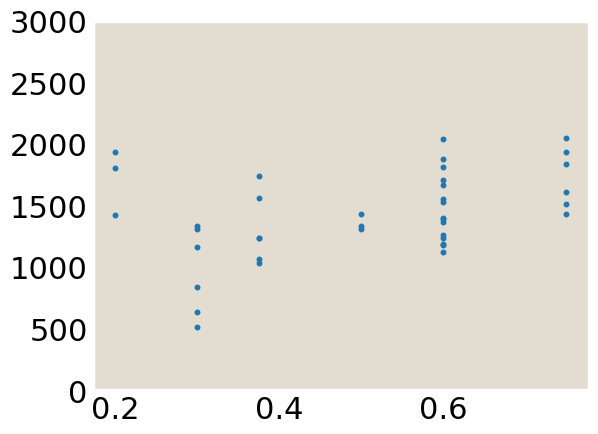

In [76]:
plt.scatter(motorconcs, np.array(motimsavgfit)[:,0], s=5)
plt.ylim(0, 3000)

(0.5, 1.0)

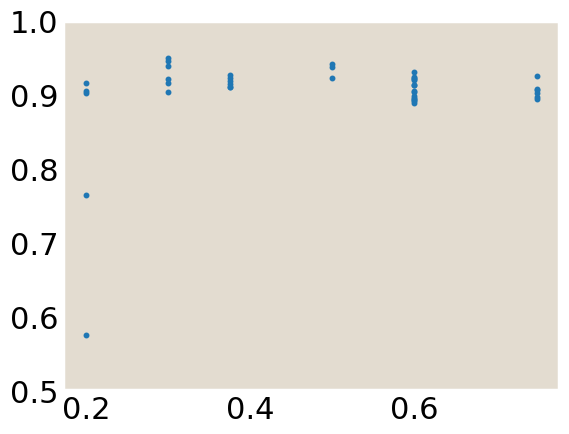

In [78]:
plt.scatter(motorconcs, np.array(motimsavgfit)[:,1], s=5)
plt.ylim(0.5, 1)

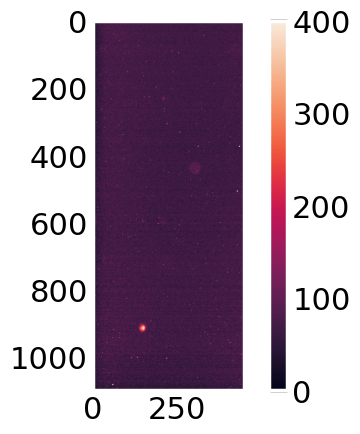

In [133]:
#plt.imshow(norm_mats_secondL[10])
plt.imshow(motimfirstLev[0], vmax=400)
plt.colorbar()

In [ ]:
mask_coords=intersect(arrs_sub)
    allmask_coords = np.s_[:, mask_coords[0], mask_coords[1]]

    arrs_norm=norm_unev(arrs_sub, mask_coords, allmask_coords)

In [25]:
postim = parse_ome('../../data/aster/Ncd_Aster_assay_12-12-2023/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2_MMStack_Pos1.ome.tif')


In [27]:
postmot = postim[2]

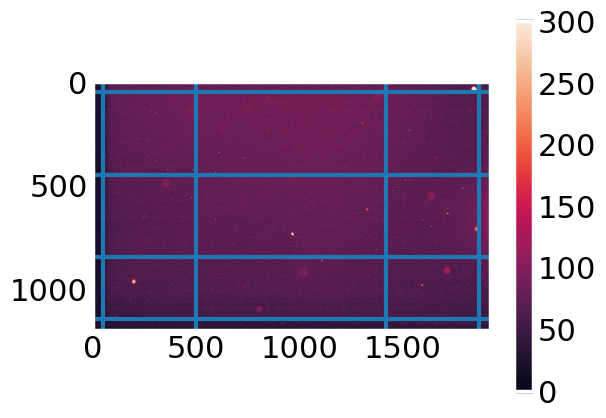

In [57]:
plt.imshow(motimsbs[0][0], vmax=300)
plt.colorbar()
plt.axhline(50)
plt.axhline(450)
plt.axhline(850)
plt.axhline(1150)
plt.axvline(50)
plt.axvline(500)
plt.axvline(1920-500)
plt.axvline(1920-50)

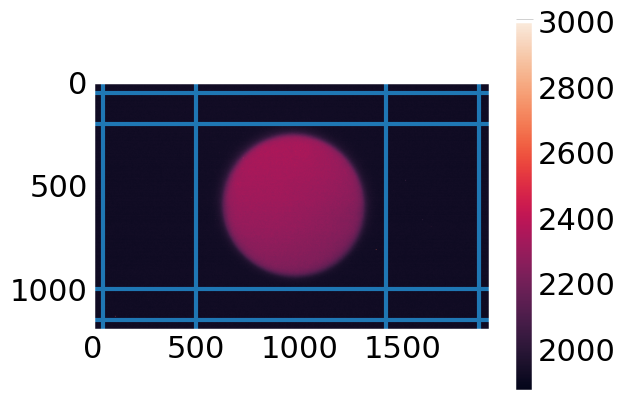

In [59]:
plt.imshow(postim[0][0], vmax=3000)
plt.colorbar()
plt.axhline(50)
plt.axhline(200)
plt.axhline(1000)
plt.axhline(1150)
plt.axvline(50)
plt.axvline(500)
plt.axvline(1920-500)
plt.axvline(1920-50)